<a href="https://colab.research.google.com/github/keerthana-narra/House-Energy-consumption-prediction/blob/main/Energy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Mounting drive & Importing data

In [ ]:
# Mounting drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings



from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn import neighbors
from sklearn.svm import SVR
import time
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from tensorflow.keras import Sequential, layers, Input
warnings.filterwarnings('ignore')

In [ ]:
#Reading data
missing_values = ['N/a', 'na', 'np-nan','None', 'none']
df = pd.read_csv("/content/drive/MyDrive/Batch-17_Mainproject/Data_notebook/energydata_complete.csv", na_values= missing_values,parse_dates=['date'])

###Understanding data

In [ ]:
df.shape #Shape of the data set

(19735, 29)

In [ ]:
df.head(2)

date  Appliances  lights  ...  Tdewpoint        rv1        rv2
0 2016-01-11 17:00:00          60      30  ...        5.3  13.275433  13.275433
1 2016-01-11 17:10:00          60      30  ...        5.2  18.606195  18.606195

[2 rows x 29 columns]

In [ ]:
df.describe() #Data Summary

Appliances        lights  ...           rv1           rv2
count  19735.000000  19735.000000  ...  19735.000000  19735.000000
mean      97.694958      3.801875  ...     24.988033     24.988033
std      102.524891      7.935988  ...     14.496634     14.496634
min       10.000000      0.000000  ...      0.005322      0.005322
25%       50.000000      0.000000  ...     12.497889     12.497889
50%       60.000000      0.000000  ...     24.897653     24.897653
75%      100.000000      0.000000  ...     37.583769     37.583769
max     1080.000000     70.000000  ...     49.996530     49.996530

[8 rows x 28 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         19735 non-null  datetime64[ns]
 1   Appliances   19735 non-null  int64         
 2   lights       19735 non-null  int64         
 3   T1           19735 non-null  float64       
 4   RH_1         19735 non-null  float64       
 5   T2           19735 non-null  float64       
 6   RH_2         19735 non-null  float64       
 7   T3           19735 non-null  float64       
 8   RH_3         19735 non-null  float64       
 9   T4           19735 non-null  float64       
 10  RH_4         19735 non-null  float64       
 11  T5           19735 non-null  float64       
 12  RH_5         19735 non-null  float64       
 13  T6           19735 non-null  float64       
 14  RH_6         19735 non-null  float64       
 15  T7           19735 non-null  float64       
 16  RH_7

In [ ]:
df.isnull().sum() #Checking for null values


date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

Renaming columns

In [ ]:
# Lowercase the column names
df.columns = [x.lower() for x in df.columns]


In [ ]:
temp_and_humid_dict = {
    't1' : 'temp_kitchen', 't2' : 'temp_living', 't3' : 'temp_laundry', 
    't4' : 'temp_office', 't5' : 'temp_bath', 't6' : 'temp_outside',
    't7' : 'temp_iron', 't8' : 'temp_teen', 't9' : 'temp_parents', 't_out' : 'temp_station',
    'rh_1' : 'humid_kitchen', 'rh_2' : 'humid_living', 'rh_3' : 'humid_laundry', 
    'rh_4' : 'humid_office', 'rh_5' : 'humid_bath', 'rh_6' : 'humid_outside',
    'rh_7' : 'humid_iron', 'rh_8' : 'humid_teen', 'rh_9' : 'humid_parents', 'rh_out' : 'humid_station', 'appliances' : 'energy'
}

In [ ]:
energy_df = df.rename(columns=temp_and_humid_dict)

In [ ]:
energy_df.head(2)

date  energy  lights  ...  tdewpoint        rv1        rv2
0 2016-01-11 17:00:00      60      30  ...        5.3  13.275433  13.275433
1 2016-01-11 17:10:00      60      30  ...        5.2  18.606195  18.606195

[2 rows x 29 columns]

In [ ]:
temp_dict =  {
    't1' : 'temp_kitchen', 't2' : 'temp_living', 't3' : 'temp_laundry', 
    't4' : 'temp_office', 't5' : 'temp_bath', 't6' : 'temp_outside',
    't7' : 'temp_iron', 't8' : 'temp_teen', 't9' : 'temp_parents', 't_out' : 'temp_station'}
humid_dict = {
    'rh_1' : 'humid_kitchen', 'rh_2' : 'humid_living', 'rh_3' : 'humid_laundry', 
    'rh_4' : 'humid_office', 'rh_5' : 'humid_bath', 'rh_6' : 'humid_outside',
    'rh_7' : 'humid_iron', 'rh_8' : 'humid_teen', 'rh_9' : 'humid_parents', 'rh_out' : 'humid_station'
}

In [ ]:
energy_df[temp_dict.values()].describe()

temp_kitchen   temp_living  ...  temp_parents  temp_station
count  19735.000000  19735.000000  ...  19735.000000  19735.000000
mean      21.686571     20.341219  ...     19.485828      7.411665
std        1.606066      2.192974  ...      2.014712      5.317409
min       16.790000     16.100000  ...     14.890000     -5.000000
25%       20.760000     18.790000  ...     18.000000      3.666667
50%       21.600000     20.000000  ...     19.390000      6.916667
75%       22.600000     21.500000  ...     20.600000     10.408333
max       26.260000     29.856667  ...     24.500000     26.100000

[8 rows x 10 columns]

**OBSERVATIONS** : 
1. **Average outside temperature over a period of 4.5 months is around 7.5 degrees. It ranges from -6 to 28 degrees**
2. **While average temperature inside the building has been around 20 degrees for all the rooms. It ranges from 14 to 30 degrees**
3. **Which implies, Warming appliances have been used to keep the insides of the building warm. There must be some sort of direct correlation between temperature and consumption of energy inside house.**

In [ ]:
energy_df[humid_dict.values()].describe()

humid_kitchen  humid_living  ...  humid_parents  humid_station
count   19735.000000  19735.000000  ...   19735.000000   19735.000000
mean       40.259739     40.420420  ...      41.552401      79.750418
std         3.979299      4.069813  ...       4.151497      14.901088
min        27.023333     20.463333  ...      29.166667      24.000000
25%        37.333333     37.900000  ...      38.500000      70.333333
50%        39.656667     40.500000  ...      40.900000      83.666667
75%        43.066667     43.260000  ...      44.338095      91.666667
max        63.360000     56.026667  ...      53.326667     100.000000

[8 rows x 10 columns]

Average humidity outside the building has been higher than the average humidity inside.
Average humidity at the weather station is significantly higher compared to outside humidity near the building.
Average humidity in the bathroom is significantly higher compared to other rooms due to obvious reasons.
Kids and parent room show a comparatively higher average humidity as well signifying the fact that, inhabitants of this building spend most of their time in these buildings.

In [ ]:
weather_cols = list(set(energy_df.columns) - set(list(temp_dict.values())) - set(list(humid_dict.values())) - {'Energy', 'lights', 'rv1', 'rv2'})
weather_cols

['windspeed', 'press_mm_hg', 'date', 'visibility', 'tdewpoint', 'energy']

### Data driven analysis of energy usage

**Distribution of our appliances energy usage**

In [ ]:
energy_df.energy.describe() 

count    19735.000000
mean        97.694958
std        102.524891
min         10.000000
25%         50.000000
50%         60.000000
75%        100.000000
max       1080.000000
Name: energy, dtype: float64

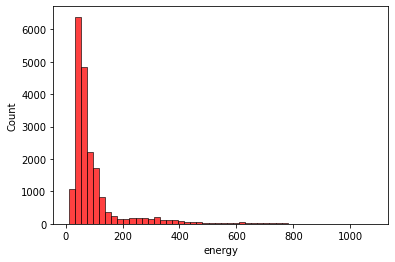

In [ ]:

sns.histplot(energy_df['energy'], color = 'red', bins=50)

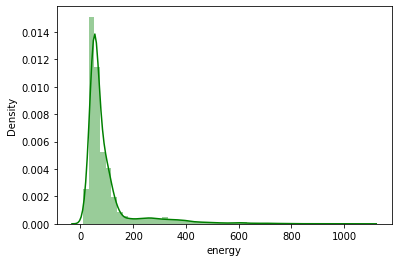

In [ ]:
sns.distplot(energy_df["energy"],color= 'green',bins= 50 )


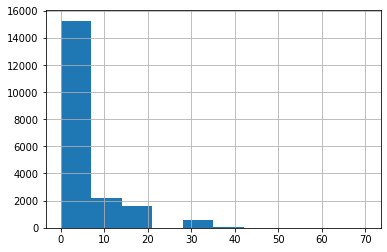

In [ ]:
energy_df.lights.hist(bins=10) 

In [ ]:
energy_df.lights.value_counts()

0     15252
10     2212
20     1624
30      559
40       77
50        9
60        1
70        1
Name: lights, dtype: int64

###Trends seen with seasonality component





In [ ]:
# Append more columns to the DataFrame based on datetime
energy_df = energy_df.set_index('date')
energy_df['month'] = energy_df.index.month
energy_df['weekday'] = energy_df.index.weekday
energy_df['hour'] = energy_df.index.hour
energy_df['week'] = energy_df.index.week

In [ ]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   energy         19735 non-null  int64  
 1   lights         19735 non-null  int64  
 2   temp_kitchen   19735 non-null  float64
 3   humid_kitchen  19735 non-null  float64
 4   temp_living    19735 non-null  float64
 5   humid_living   19735 non-null  float64
 6   temp_laundry   19735 non-null  float64
 7   humid_laundry  19735 non-null  float64
 8   temp_office    19735 non-null  float64
 9   humid_office   19735 non-null  float64
 10  temp_bath      19735 non-null  float64
 11  humid_bath     19735 non-null  float64
 12  temp_outside   19735 non-null  float64
 13  humid_outside  19735 non-null  float64
 14  temp_iron      19735 non-null  float64
 15  humid_iron     19735 non-null  float64
 16  temp_teen      19735 non-null  float64
 17  humid_teen     

Text(0, 0.5, 'energy consumed (Wh)')

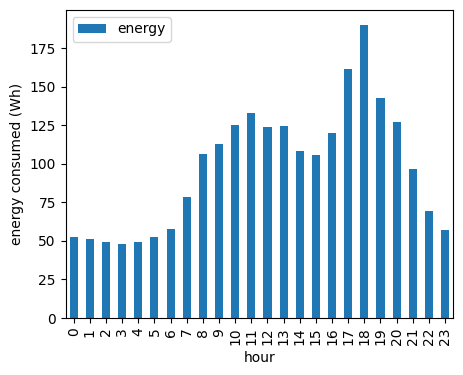

In [ ]:
#Energy consumed Vs hour plot
plt.style.use('default')
fig, ax = plt.subplots(1,1,figsize=(5,4))
plt.grid(color='w', linestyle='solid')
ax.set_axisbelow(True)
energy_df.groupby('hour').agg({'energy' : 'mean'}).plot.bar(ax=ax)
ax.set_ylabel('energy consumed (Wh)')

**Above figure is a representation of average energy consumption of appliances at different time of the day over a period of 4.5 months. We observe two peak hours. One at 11 am in the morning and other at 6 PM in the evening. While the peak at 11 am is shallow and low, peak at 6 PM is comparatively higher and sharper.**

**We observe that over the sleeping hours (10 PM - 6 AM) the energy consumption of appliances is around 50 Wh. After about 6 AM, energy consumption starts to rise gradually up until 11 AM (probably due to morning chores). And then gradually decreases to around 100 Wh at about 3 PM. After which the energy consumption drastically shoots up up until 6 PM in the evening (probably due to requirement lights in rooms). However energy consumption of appliances reverts back to 50 Wh, as night approaches and people in the house go to bed at around 10 PM.**

Text(0, 0.5, 'Appliance enrergy (Wh)')

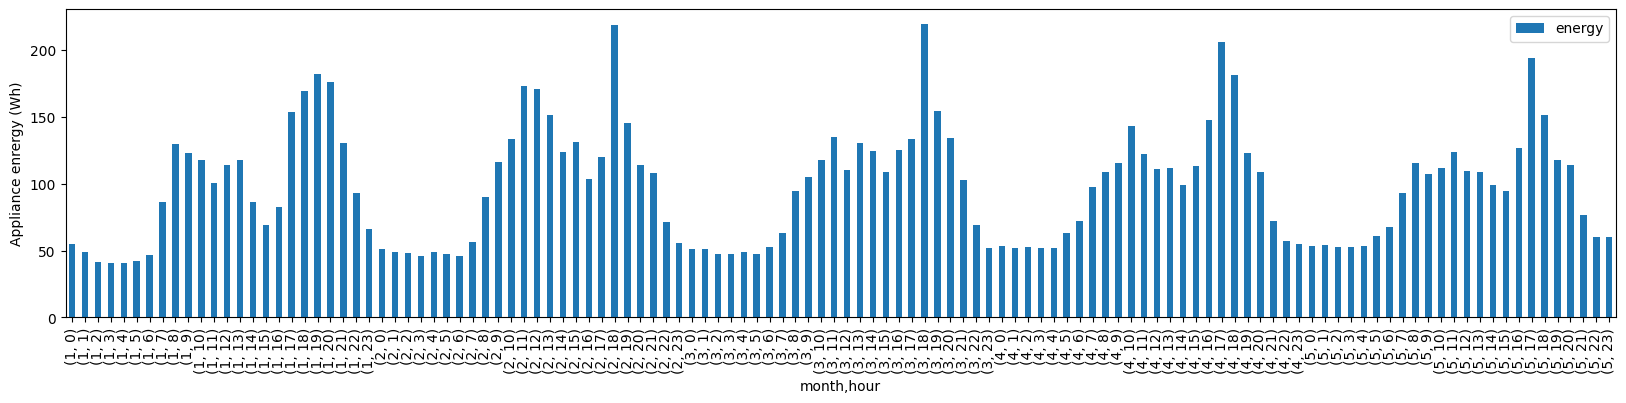

In [ ]:
# Energy Vs month,hour plot
fig, ax = plt.subplots(1,1,figsize=(20,4))
energy_df.groupby(['month','hour']).agg({'energy' : 'mean'}).plot.bar(ax=ax)
ax.set_ylabel('Appliance enrergy (Wh)')

**A trend of high consumption hours for each month seems to be similar to the over all trend** Seems like 6-7pm time is a peak of every day

What about weekdays and weekends

Text(0, 0.5, 'Appliance Energy (Wh)')

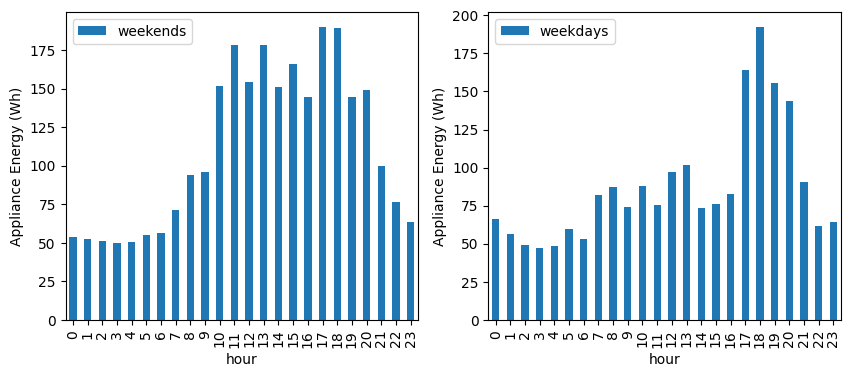

In [ ]:
#Energy consumed Vs hour plots on weekdays and weekends
fig, ax = plt.subplots(1,2,figsize=(10,4))
week_df = energy_df.groupby(['weekday','hour']).agg({'energy':'mean'}).reset_index(0)
week_df[week_df.weekday==0].energy.plot.bar(ax=ax[0], label='weekends')
week_df[week_df.weekday==1].energy.plot.bar(ax=ax[1], label='weekdays')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[0].set_ylabel('Appliance Energy (Wh)')
ax[1].set_ylabel('Appliance Energy (Wh)')

**We observe that the energy consumption of appliances during the office hours (8 AM - 4 PM) is higher in weekends compared to the weekdays. Also, average overall consumption is higher in weekends is pretty high.**

**Lets look at how temperature and humidity levels vary inside different rooms !**

###Temperature levels

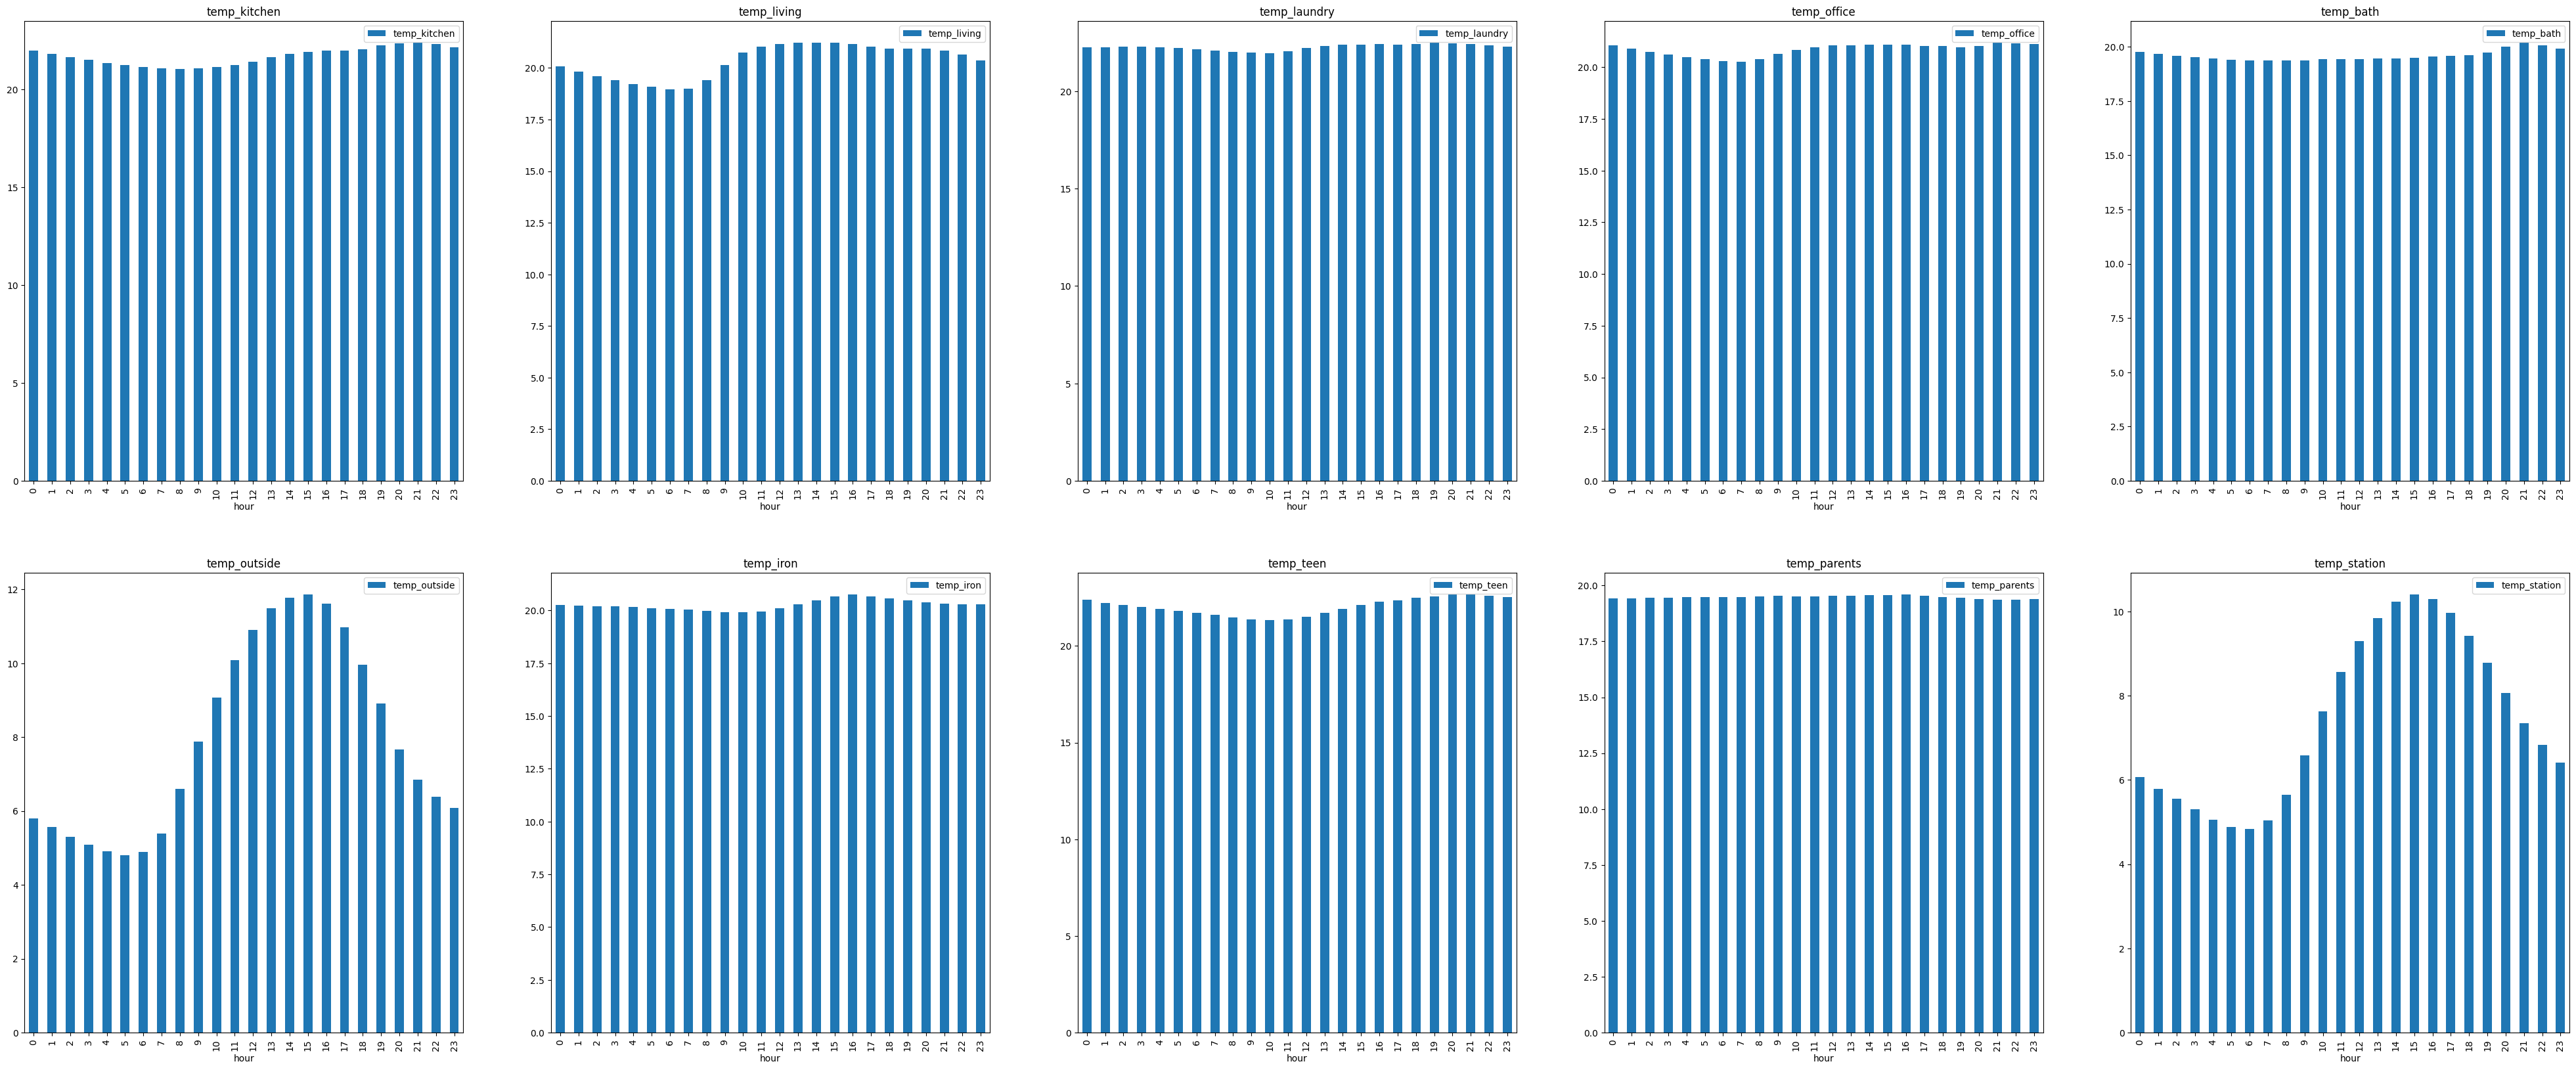

In [ ]:
fig, axes = plt.subplots(2,5,figsize=(50,20))
for i, temp in enumerate(temp_dict.values()):
  energy_df.groupby('hour').agg({temp : 'mean'}).plot.bar(ax=axes[i//5, i%5])
  axes[i//5, i%5].legend(loc='best')
  axes[i//5, i%5].set_title(temp)

**The average temperature inside each of the rooms has been almost constant over the day. However the average temperature outside the building and near the station changes over the course of the day. The average night time temperature is around 6 degree C, while average day time temperature peaks at about 2-3 PM in the afternoon.**

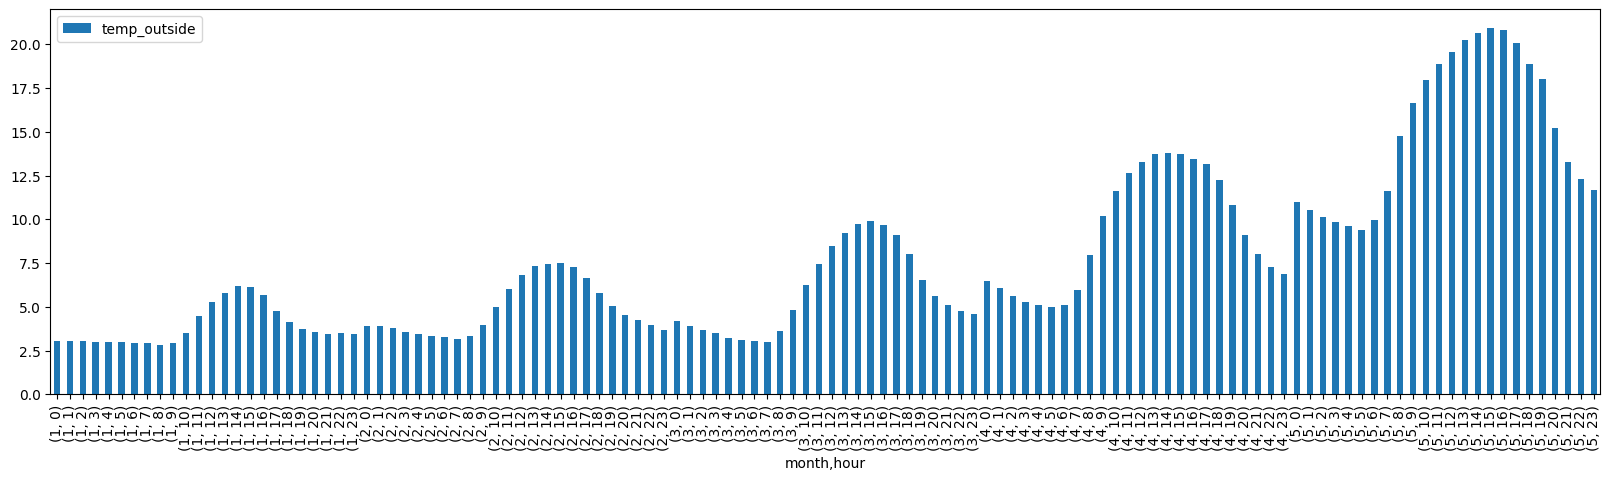

In [ ]:
#temperature variation in month,hour
fig, ax = plt.subplots(1,1,figsize=(20,5))
energy_df.groupby(['month','hour']).agg({'temp_outside' : 'mean'}).plot.bar(ax=ax)

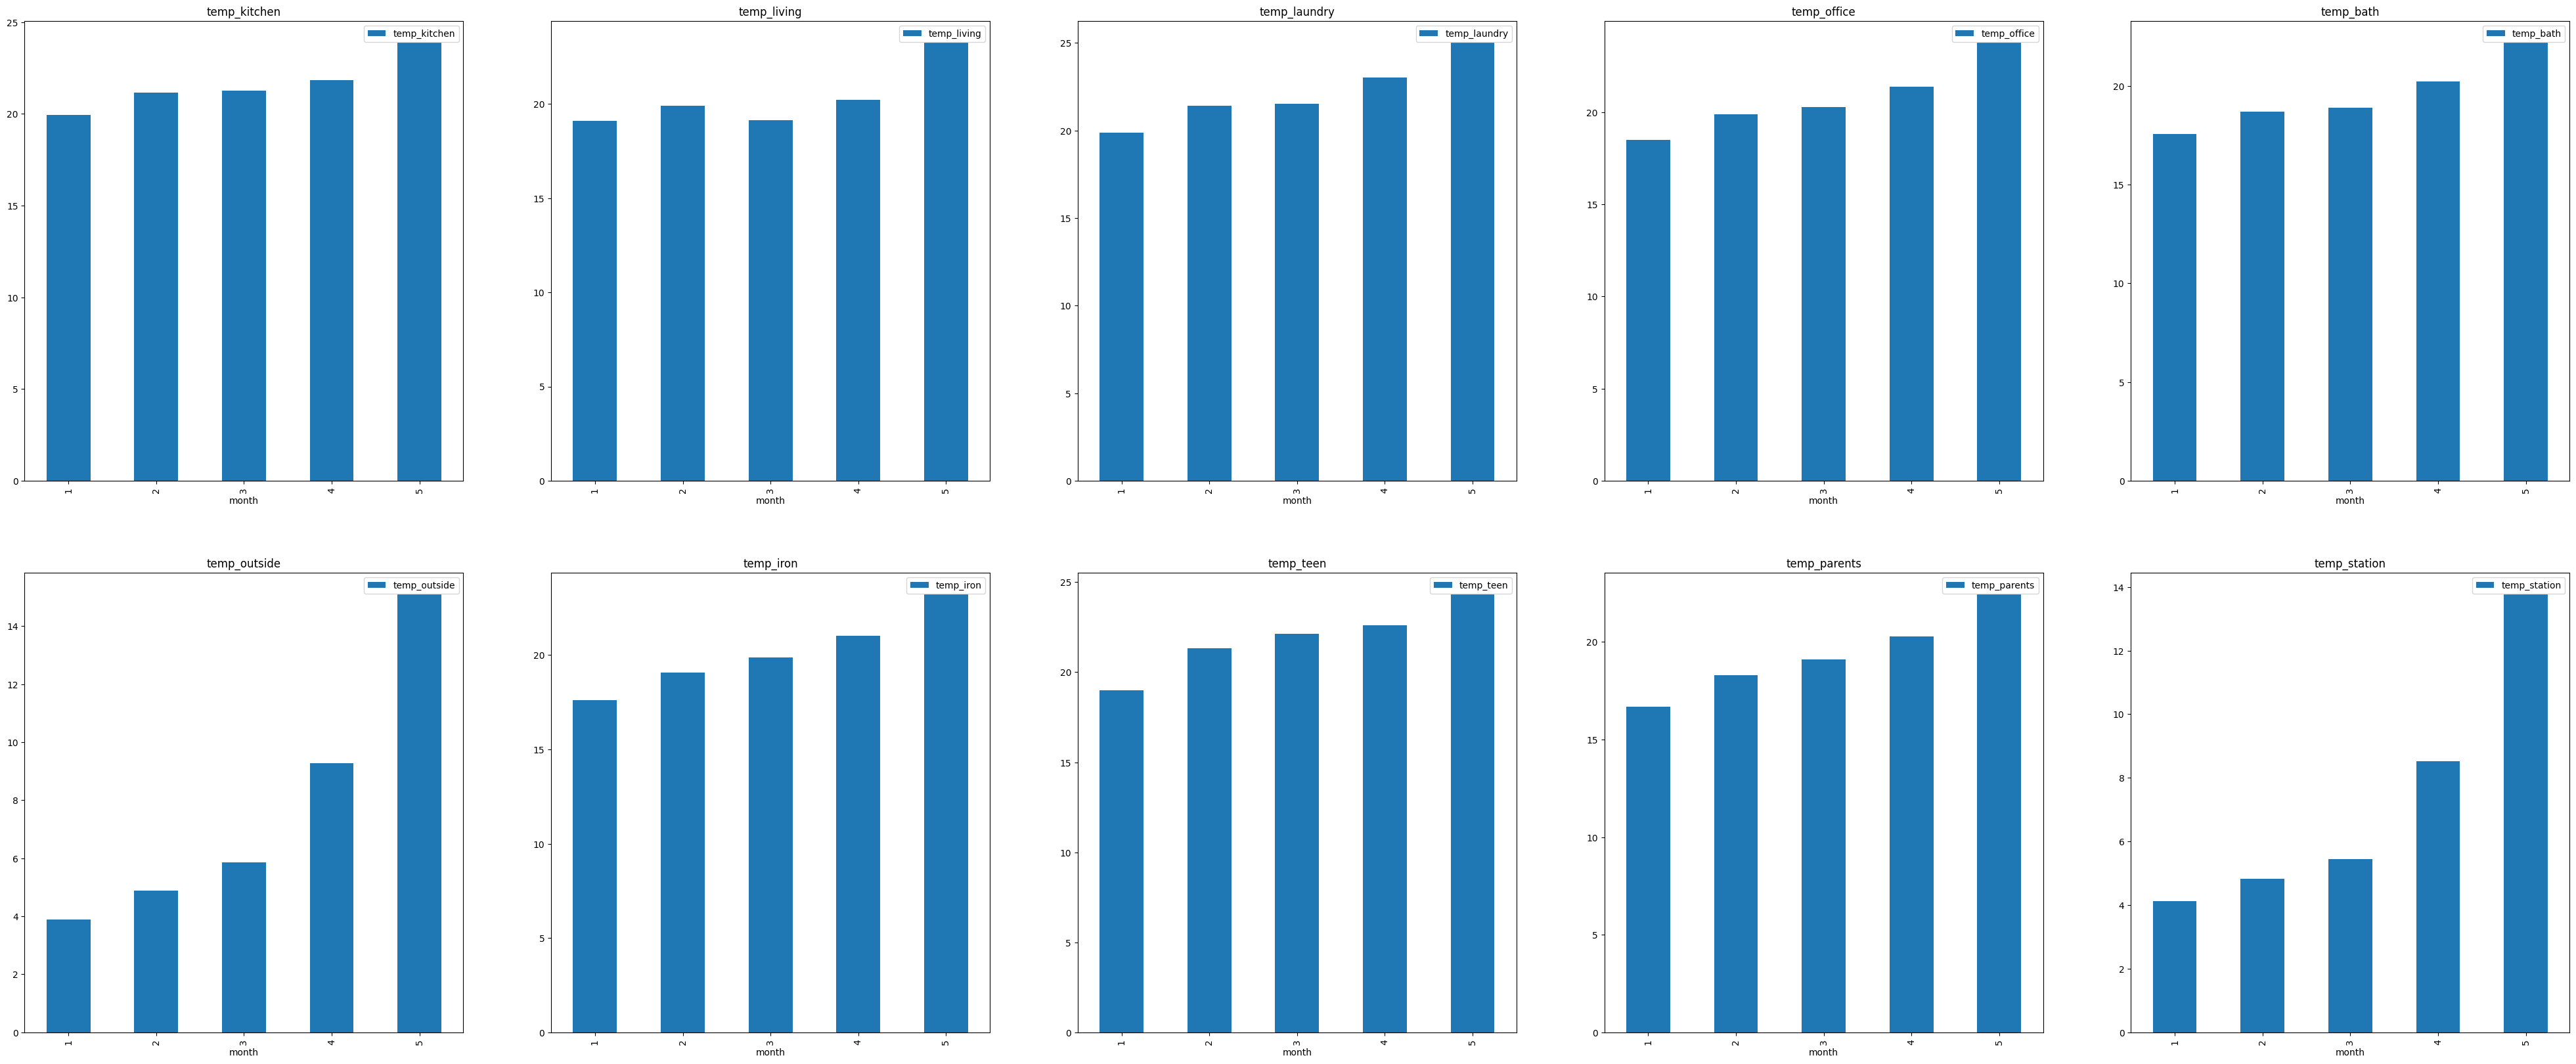

In [ ]:
fig, axes = plt.subplots(2,5,figsize=(50,20))
for i, temp in enumerate(temp_dict.values()):
  energy_df.groupby('month').agg({temp : 'mean'}).plot.bar(ax=axes[i//5, i%5])
  axes[i//5, i%5].legend(loc='best')
  axes[i//5, i%5].set_title(temp)

We observe a significant increasing trend of daytime outside temperatures over the course of 5 months starting from an avg of 4 degree celsius in 1st month to an average of 15 degree celsius in month 5. The outside temperatures seem to have an impact over temperature inside too, although the variance of temperatures inside the building is low, since the temperature inside is controlled. Although the increase temperature seem to have no impact on the appliance consumtion patterns.

###Humidity levels

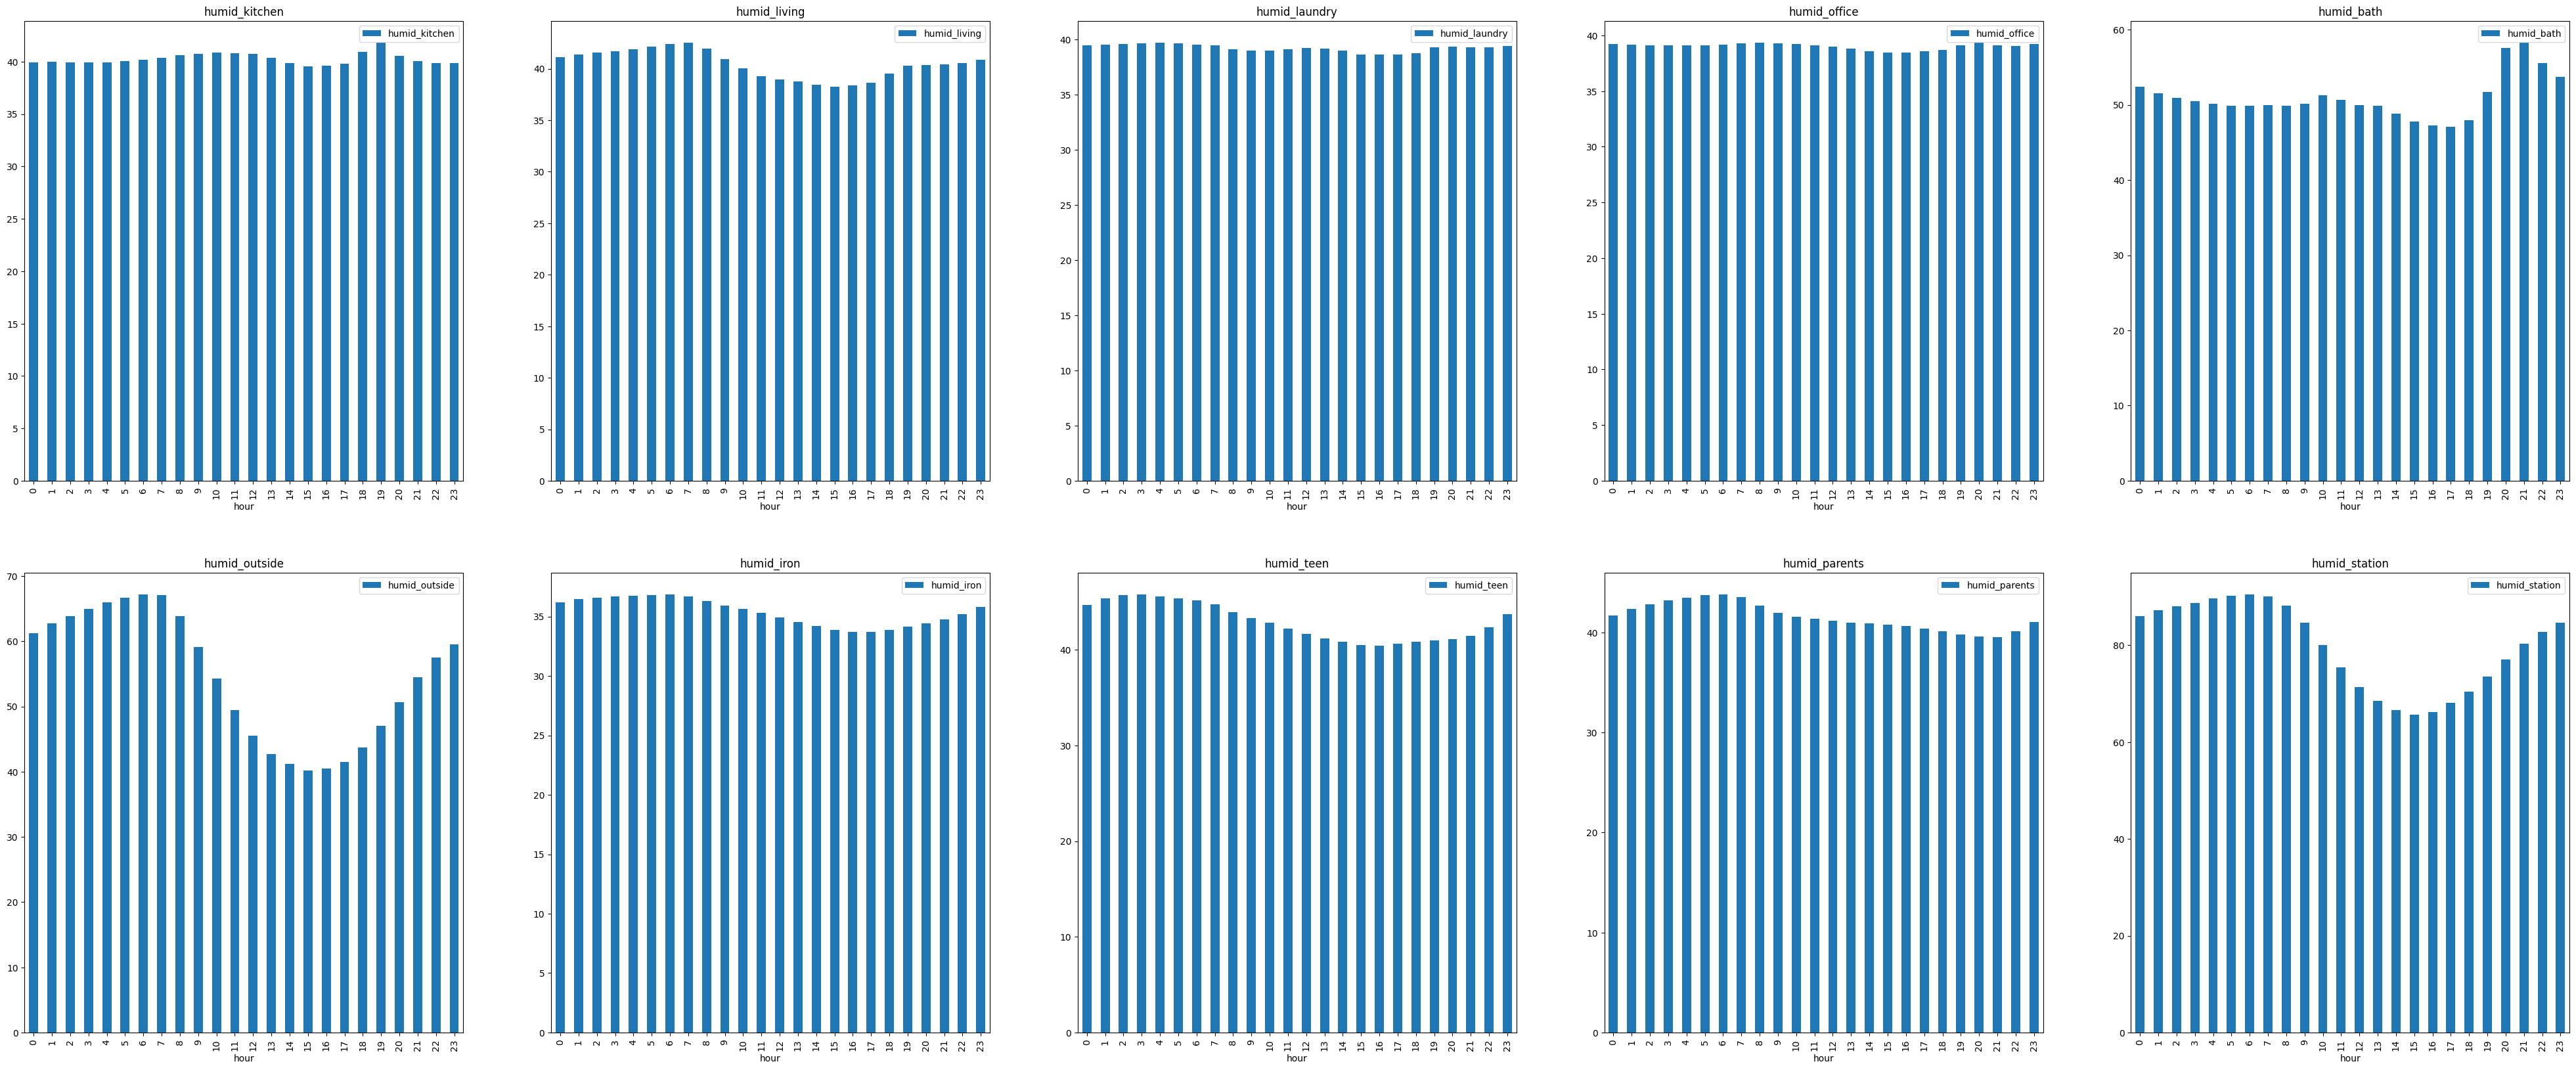

In [ ]:
fig, axes = plt.subplots(2,5,figsize=(50,20))
for i, humid in enumerate(humid_dict.values()):
  energy_df.groupby('hour').agg({humid : 'mean'}).plot.bar(ax=axes[i//5, i%5])
  axes[i//5, i%5].legend(loc='best')
  axes[i//5, i%5].set_title(humid)

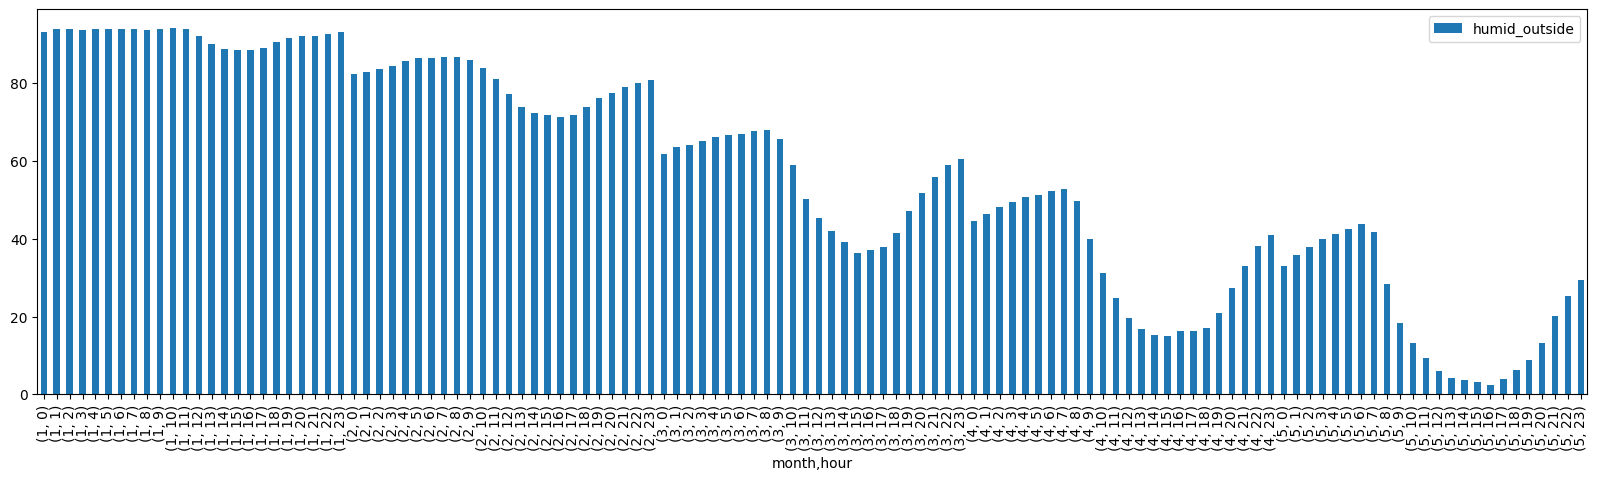

In [ ]:
#humidity variation in month,hour
fig, ax = plt.subplots(1,1,figsize=(20,5))
energy_df.groupby(['month','hour']).agg({'humid_outside' : 'mean'}).plot.bar(ax=ax)

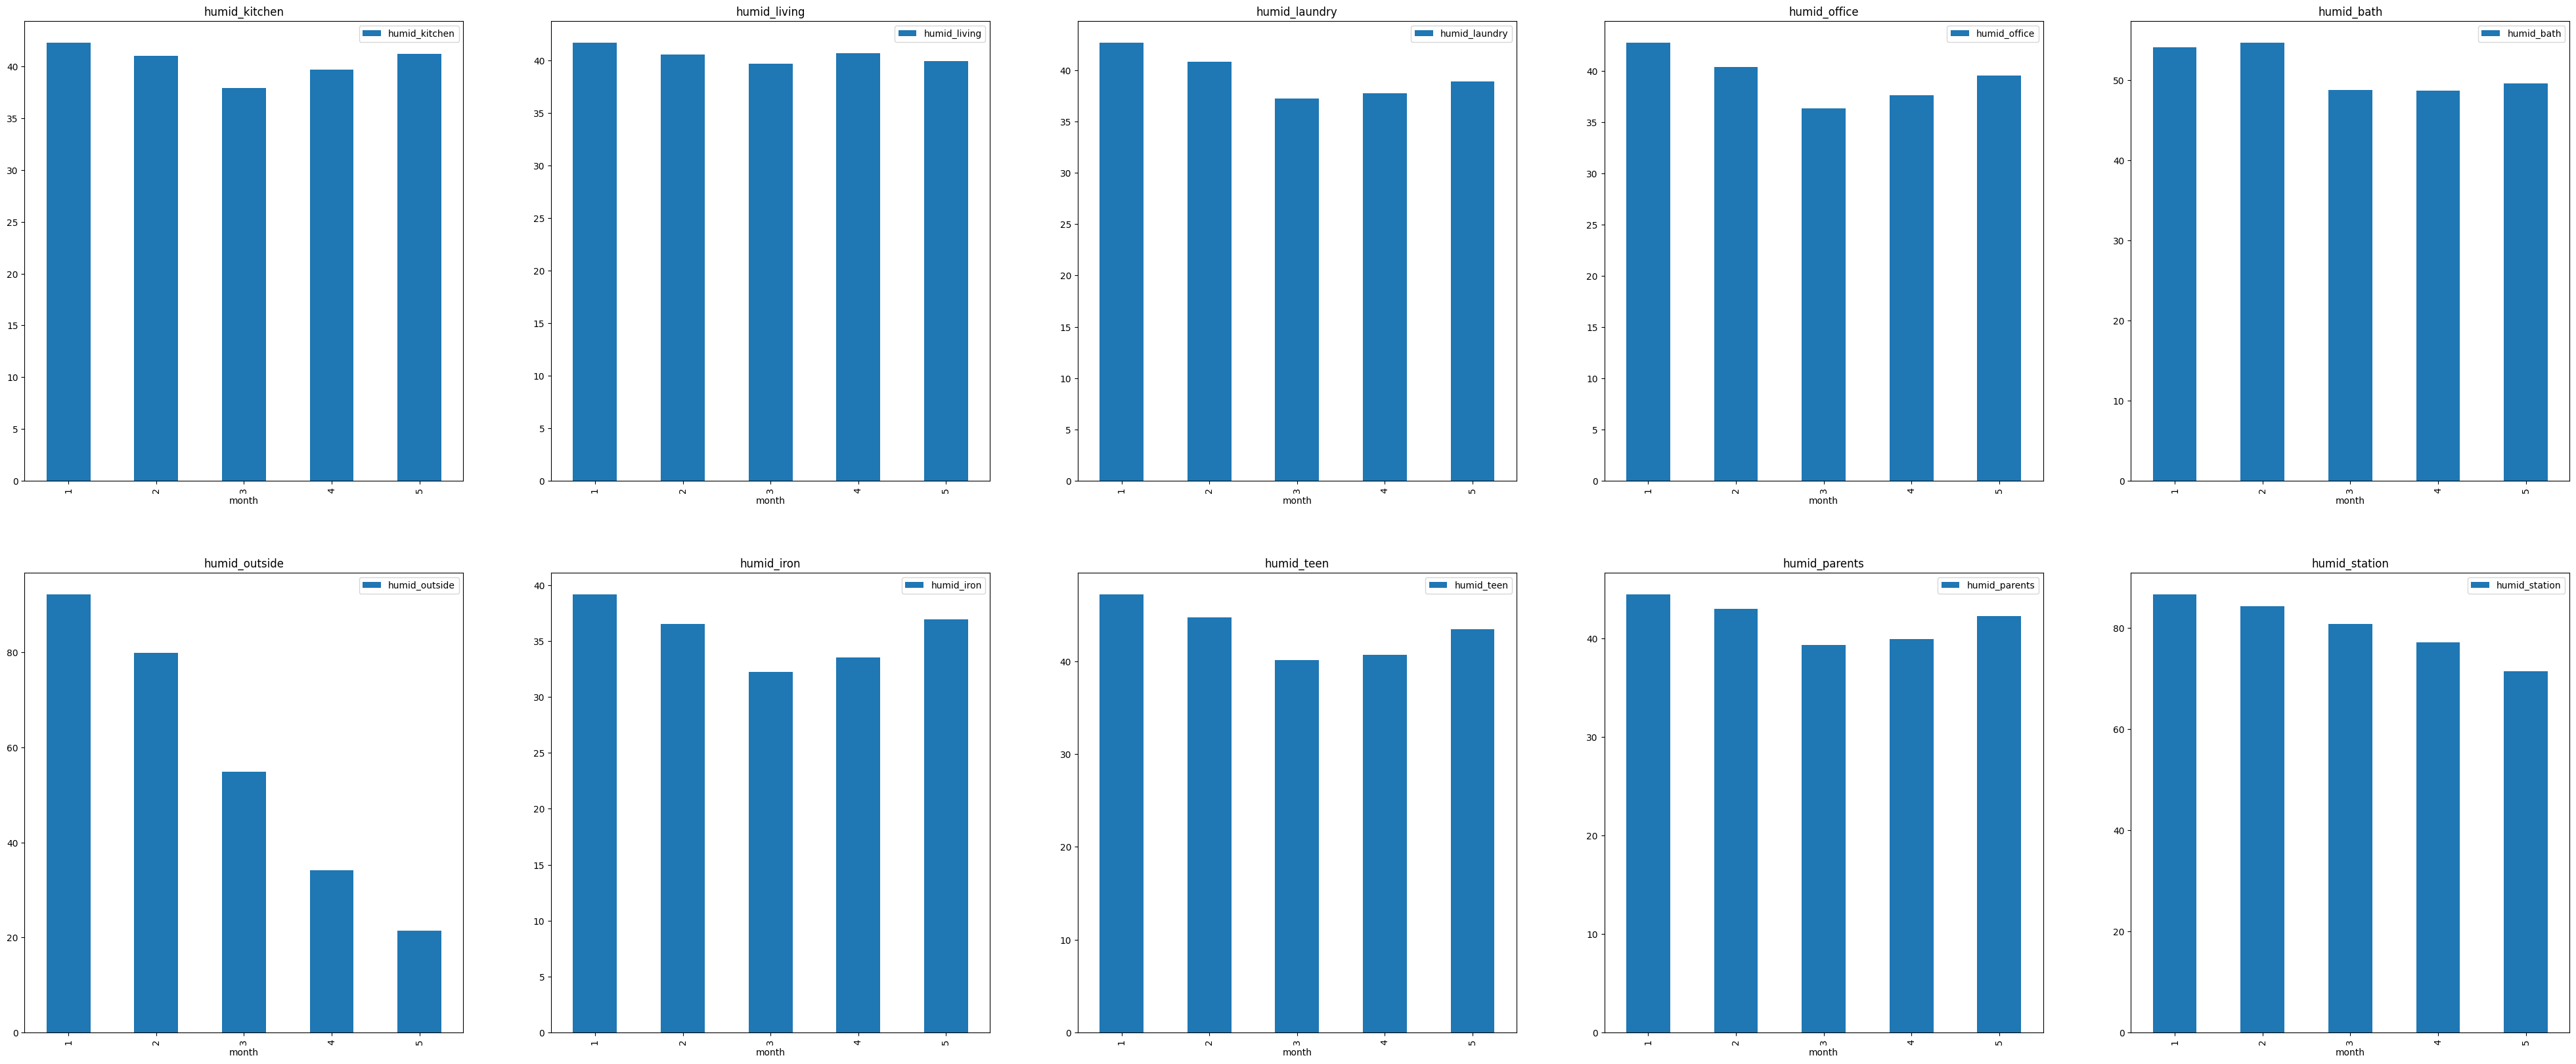

In [ ]:
fig, axes = plt.subplots(2,5,figsize=(50,20))
for i, humid in enumerate(humid_dict.values()):
  energy_df.groupby('month').agg({humid : 'mean'}).plot.bar(ax=axes[i//5, i%5])
  axes[i//5, i%5].legend(loc='best')
  axes[i//5, i%5].set_title(humid)

**Although the humidity outside building tend to decrease over months, the humidity inside rooms seem to be unaffected. The humidity levels outside seem to be negatively correlated to with the temperature levels outside. Lets check !**

In [ ]:
energy_df[['temp_outside', 'humid_outside','energy']].corr()

temp_outside  humid_outside    energy
temp_outside       1.000000      -0.671619  0.122468
humid_outside     -0.671619       1.000000 -0.087261
energy             0.122468      -0.087261  1.000000

**Indeed there is a strong negative correlation between temperature and humidity levels outside. As temperature increases, moisture levels in the air decreases. We also observe that during the day time when the temperatures are high, humidity levels are low.**

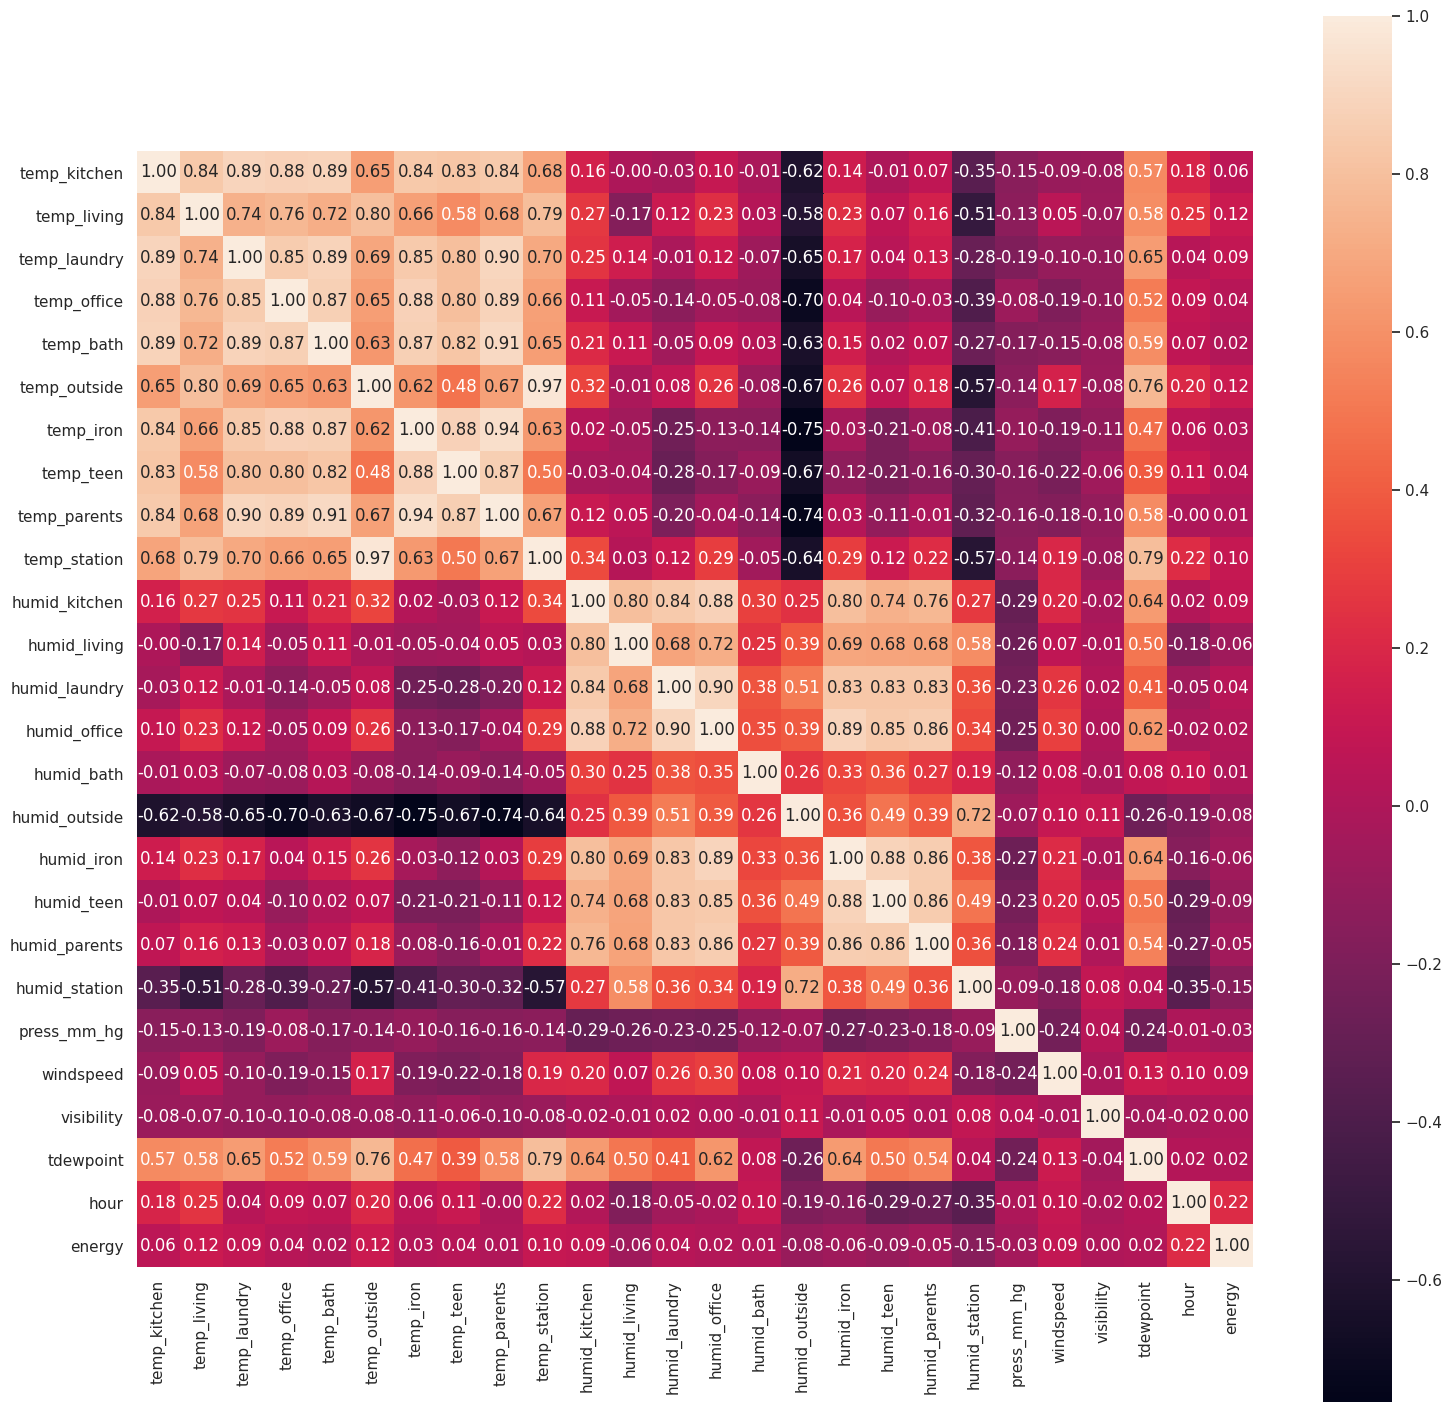

In [ ]:
# Pearson Correlation among the variables

col = ['temp_kitchen', 'temp_living', 'temp_laundry', 
     'temp_office', 'temp_bath',  'temp_outside',
    'temp_iron',  'temp_teen', 'temp_parents',  'temp_station',
     'humid_kitchen', 'humid_living', 'humid_laundry', 
     'humid_office',  'humid_bath', 'humid_outside',
    'humid_iron', 'humid_teen', 'humid_parents',  'humid_station','press_mm_hg',  'windspeed', 'visibility',
       'tdewpoint','hour','energy']

corr = energy_df[col].corr()
plt.figure(figsize = (18,18))
sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.2f', xticklabels=col, yticklabels=col)
plt.show();


##Feature Engineering

Check for outliers: We will consider as outliers the 0,1% top values of appliances' load because it is fact that recordings of power load higher than 800Wh from a house appliance are not logical. These may be false recordings caused by an instant fault on the recording devices. Additionally, in this data set there are not any NA values.

The number of the 0.5% top values of load is 39 and they have power load higher than 740 Wh.


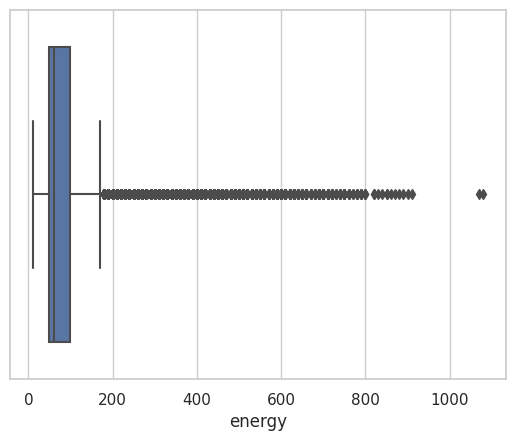

In [ ]:
# Find outliers
sorted_energy = energy_df.sort_values('energy',ascending=False)
sorted_energy.reset_index(drop=True,inplace = True)
print("The number of the 0.5% top values of load is",
      len(sorted_energy.head(len(sorted_energy)//500)),"and they have power load higher than",
      sorted_energy.energy[39], "Wh.")

# boxplot appliances
sns.set(style="whitegrid")
ax = sns.boxplot(sorted_energy.energy)

The idea is that appliances' load is hour, day, week, month dependent. It is logical assumption that in night hours the load is low or at weekends the energy consumption is higher than the weekdays because more people are at home.

Additionaly, it is expected a correlation between temperature/humidity and energy load. For instance, when someone cooks(higher consumption) probably the temperature in the kichen raises.

Moreover, we can use qualitative predictors to indicate if a mesured load is lower or higher in comparison to the average energy load a given time interval.

I will append several columns as new features to the original data, based on the above-mentioned assumptions and then i will find out which of them explain better appliances consumption.

In [ ]:
# Outliers removal

energy_df = energy_df.dropna()
energy_df = energy_df.drop(energy_df[(energy_df.energy>740)|(energy_df.energy<0)].index)

### Energy consumption patterns

In [ ]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19697 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   energy         19697 non-null  int64  
 1   lights         19697 non-null  int64  
 2   temp_kitchen   19697 non-null  float64
 3   humid_kitchen  19697 non-null  float64
 4   temp_living    19697 non-null  float64
 5   humid_living   19697 non-null  float64
 6   temp_laundry   19697 non-null  float64
 7   humid_laundry  19697 non-null  float64
 8   temp_office    19697 non-null  float64
 9   humid_office   19697 non-null  float64
 10  temp_bath      19697 non-null  float64
 11  humid_bath     19697 non-null  float64
 12  temp_outside   19697 non-null  float64
 13  humid_outside  19697 non-null  float64
 14  temp_iron      19697 non-null  float64
 15  humid_iron     19697 non-null  float64
 16  temp_teen      19697 non-null  float64
 17  humid_teen     

In [ ]:
energy_df.tail(5)

energy  lights  temp_kitchen  ...  weekday  hour  week
date                                               ...                     
2016-05-27 17:20:00     100       0     25.566667  ...        4    17    21
2016-05-27 17:30:00      90       0     25.500000  ...        4    17    21
2016-05-27 17:40:00     270      10     25.500000  ...        4    17    21
2016-05-27 17:50:00     420      10     25.500000  ...        4    17    21
2016-05-27 18:00:00     430      10     25.500000  ...        4    18    21

[5 rows x 32 columns]

In [ ]:
#log energy
energy_df['log_energy'] = np.log(energy_df.energy)

# Average house temperature and humidity
energy_df['avg_house_temp'] =(energy_df.temp_kitchen + energy_df.temp_living + energy_df.temp_laundry + energy_df.temp_office + energy_df.temp_bath + energy_df.temp_iron + energy_df.temp_teen + energy_df.temp_parents)/8
#print('average house temp is', avg_house_temp)
energy_df['avg_house_hum'] =(energy_df.humid_kitchen + energy_df.humid_living + energy_df.humid_laundry + energy_df.humid_office + energy_df.humid_bath + energy_df.humid_iron + energy_df.humid_teen + energy_df.humid_parents)/8
#print('average house hum is', avg_house_hum)

# Products of several features to remove additive assumption(An Introducton to Statistical learning p. 87,88)
energy_df['hour*lights'] = energy_df.hour * energy_df.lights

energy_df['th_kitchen'] = energy_df.temp_kitchen * energy_df.humid_kitchen
energy_df['th_living'] = energy_df.temp_living * energy_df.humid_living
energy_df['th_laundry'] = energy_df.temp_laundry * energy_df.humid_laundry
energy_df['th_office'] = energy_df.temp_office * energy_df.humid_office
energy_df['th_bath'] = energy_df.temp_bath * energy_df.humid_bath
energy_df['th_iron'] = energy_df.temp_iron * energy_df.humid_iron
energy_df['th_teen'] = energy_df.temp_teen * energy_df.humid_teen
energy_df['th_parents'] = energy_df.temp_parents * energy_df.humid_parents
energy_df['th_outside'] = energy_df.temp_outside * energy_df.humid_outside


In [ ]:
energy_df.head(1)
               

energy  lights  ...  th_parents  th_outside
date                                 ...                        
2016-01-11 17:00:00      60      30  ...  775.527667  592.043511

[1 rows x 45 columns]

In [ ]:
energy_df.shape

(19697, 45)

In [ ]:
#energy_df['RH'] = pow(10,    7.591*((energy_df['Tdewpoint']/(energy_df['Tdewpoint']+240.72)-(energy_df['temp_station']/(energy_df['temp_station']+240.72)))))*100

In [ ]:
# Calculate average energy load per weekday and hour
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())


In [ ]:
# Average energy consumption per weekday and hour
weekday_avg = list(map(
    code_mean(energy_df[:], 'weekday', "energy").get, energy_df.weekday))
print(weekday_avg[0])
hour_avg= list(map(
    code_mean(energy_df[:], 'hour', "energy").get, energy_df.hour))
print(hour_avg[0])

109.95670995670996
156.56934306569343


In [ ]:
# Data sets in 30 minitues and 1 hour basis

energy_df_hour = energy_df.resample('1H').mean()
energy_df_30min =energy_df.resample('30min').mean()

In [ ]:
# Qualitative predictors 
'''We assume that we have low(high) energy load when the appliances consumption is lower(higher) 
   than a given point of the hourly average counsumption. This point is dependent of data time frequency 
   and the numbers below are set after several tryouts based on appliances' consumption standard deviation.


energy_df['low_consum'] = (energy_df.energy+25<(energy_df.hour_avg))*1
energy_df['high_consum'] = (energy_df.energy+100>(energy_df.hour_avg))*1


energy_df_hour['low_consum'] = (energy_df_hour.energy+25<(energy_df_hour.hour_avg))*1
energy_df_hour['high_consum'] = (energy_df_hour.energy+25>(energy_df_hour.hour_avg))*1



energy_df_30min['low_consum'] = (energy_df_30min.energy+25<(energy_df_30min.hour_avg))*1
energy_df_30min['high_consum'] = (energy_df_30min.energy+35>(energy_df_30min.hour_avg))*1'''



"We assume that we have low(high) energy load when the appliances consumption is lower(higher) \n   than a given point of the hourly average counsumption. This point is dependent of data time frequency \n   and the numbers below are set after several tryouts based on appliances' consumption standard deviation.\n\n\nenergy_df['low_consum'] = (energy_df.energy+25<(energy_df.hour_avg))*1\nenergy_df['high_consum'] = (energy_df.energy+100>(energy_df.hour_avg))*1\n\n\nenergy_df_hour['low_consum'] = (energy_df_hour.energy+25<(energy_df_hour.hour_avg))*1\nenergy_df_hour['high_consum'] = (energy_df_hour.energy+25>(energy_df_hour.hour_avg))*1\n\n\n\nenergy_df_30min['low_consum'] = (energy_df_30min.energy+25<(energy_df_30min.hour_avg))*1\nenergy_df_30min['high_consum'] = (energy_df_30min.energy+35>(energy_df_30min.hour_avg))*1"

In [ ]:
energy_df.head(2)

energy  lights  ...  th_parents  th_outside
date                                 ...                        
2016-01-11 17:00:00      60      30  ...  775.527667  592.043511
2016-01-11 17:10:00      60      30  ...  777.557333  574.432778

[2 rows x 45 columns]

In [ ]:
# Functions to be used from the plots

def daily(x,energy_df=energy_df):
    return energy_df.groupby('weekday')[x].mean()
def hourly(x,energy_df=energy_df):
    return energy_df.groupby('hour')[x].mean()

def monthly_daily(x,energy_df=energy_df):
    by_day = energy_df.pivot_table(index='weekday', 
                                columns=['month'],
                                values=x,
                                aggfunc='mean')
    return round(by_day, ndigits=2)

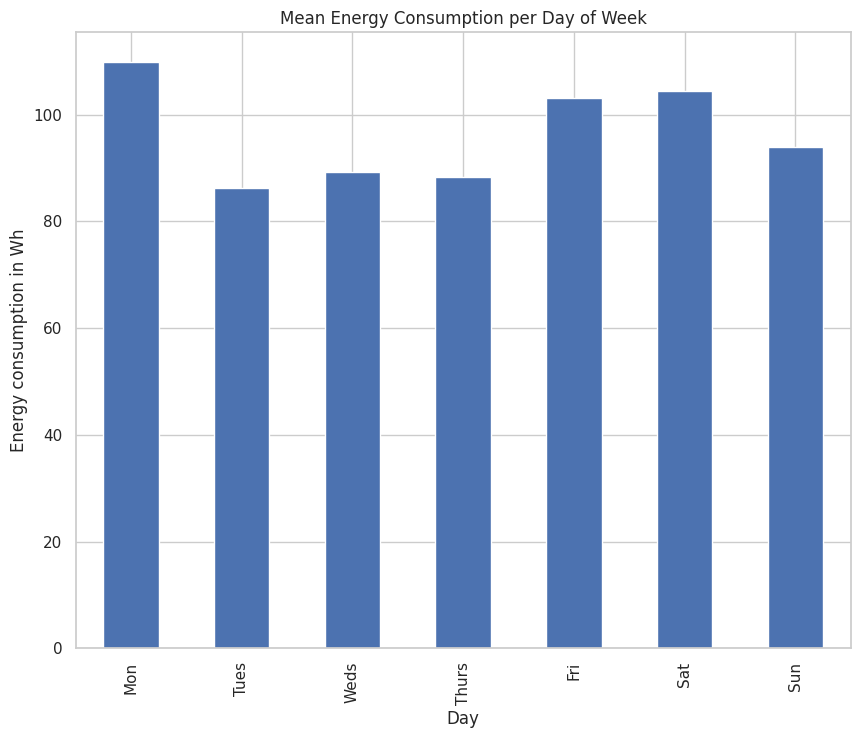

In [ ]:
# Plot of Mean Energy Consumption per Day of Week

daily('energy').plot(kind = 'bar', figsize=(10,8))
ticks = list(range(0, 7, 1)) 
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xlabel('Day')
plt.ylabel('Energy consumption in Wh')
plt.title('Mean Energy Consumption per Day of Week')
plt.xticks(ticks, labels);

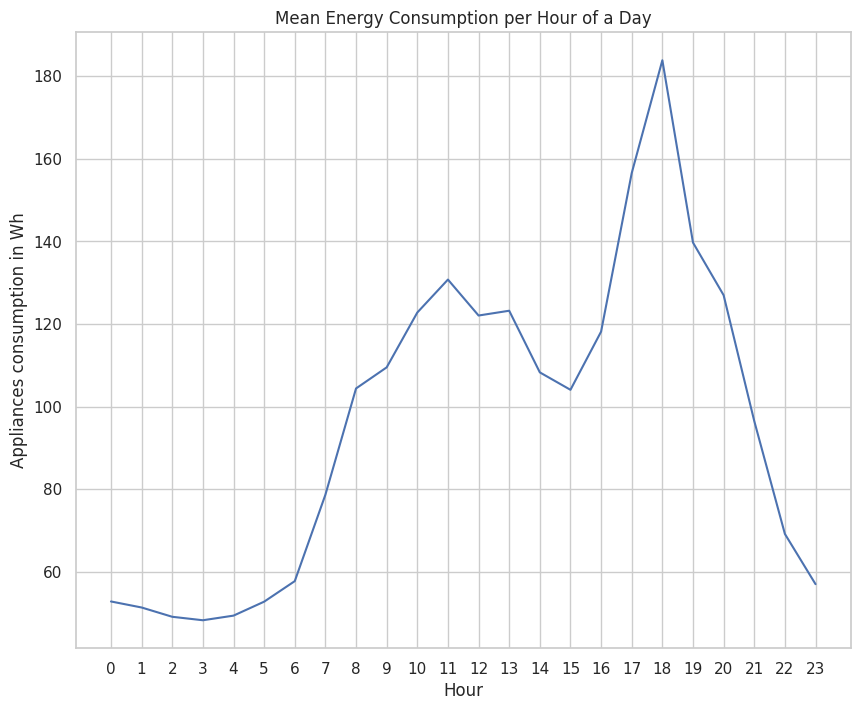

In [ ]:
# Plot of Mean Energy Consumption per Hour of a Day

hourly('energy').plot(figsize=(10,8))
plt.xlabel('Hour')
plt.ylabel('Appliances consumption in Wh')
ticks = list(range(0, 24, 1))
plt.title('Mean Energy Consumption per Hour of a Day')

plt.xticks(ticks);


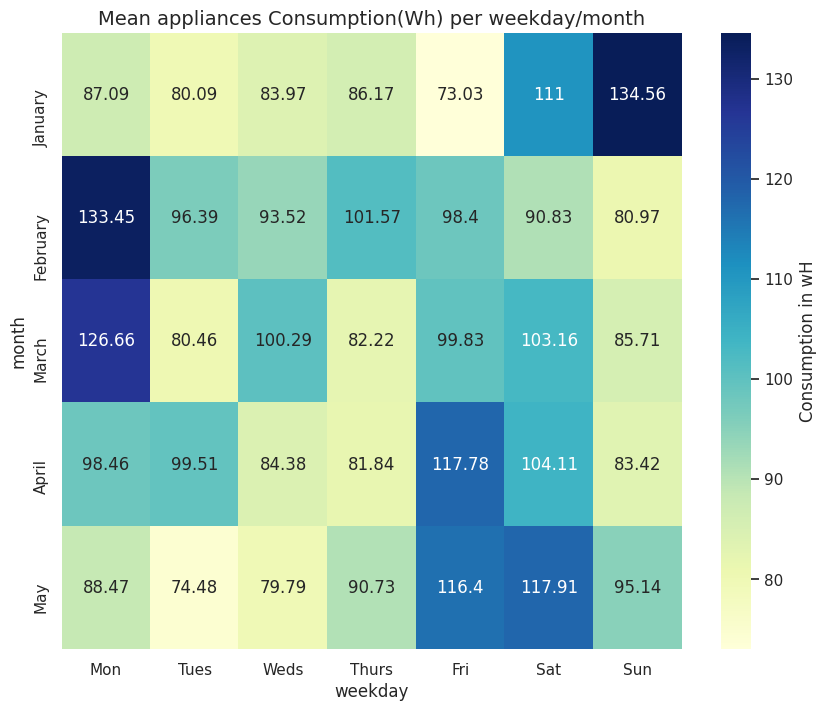

In [ ]:
# Heatmap: Mean consumption per Weekday of Month
sns.set(rc={'figure.figsize':(10,8)},)
ax=sns.heatmap(monthly_daily('energy').T,cmap="YlGnBu",
               xticklabels="Mon Tues Weds Thurs Fri Sat Sun".split(),
               yticklabels="January February March April May".split(),
               annot=True, fmt='g',
               cbar_kws={'label': 'Consumption in wH'}).set_title("Mean appliances Consumption(Wh) per weekday/month").set_fontsize('14')

plt.show()



Text(0.5, 0, 'Energy log(wH)')

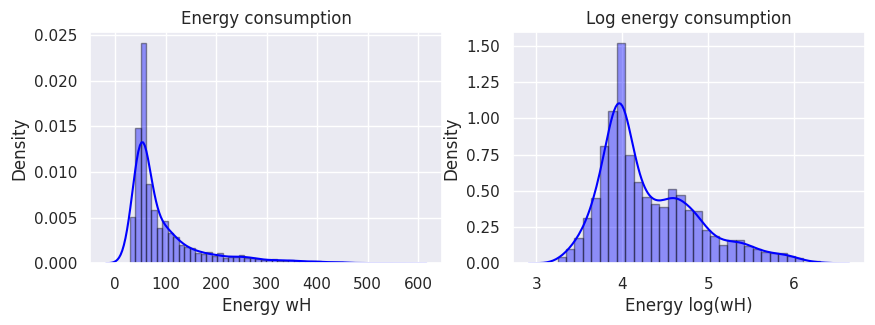

In [ ]:
#Histogram of Appliance's consumption

f, axes = plt.subplots(1, 2,figsize=(10,3))


sns.distplot(energy_df_hour.energy, hist=True, color = 'blue',hist_kws={'edgecolor':'black'},ax=axes[0])
axes[0].set_title("Energy consumption")
axes[0].set_xlabel('Energy wH')

sns.distplot(energy_df_hour.log_energy, hist=True, color = 'blue',hist_kws={'edgecolor':'black'},ax=axes[1])
axes[1].set_title("Log energy consumption")
axes[1].set_xlabel('Energy log(wH)')

In [ ]:
'''numeric_features = energy_df.columns
numeric_features
for col in numeric_features[1:-1]:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = energy_df[col]
    label =  energy_df['Appliances']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('energy')
    ax.set_title('energy vs ' + col + '- correlation: ' + str(correlation))
    z = np.polyfit(energy_df[col], energy_df['Appliances'], 1)
    y_hat = np.poly1d(z)(energy_df[col])

    plt.plot(energy_df[col], y_hat, "r--", lw=1)

plt.show()'''

'numeric_features = energy_df.columns\nnumeric_features\nfor col in numeric_features[1:-1]:\n    fig = plt.figure(figsize=(9, 6))\n    ax = fig.gca()\n    feature = energy_df[col]\n    label =  energy_df[\'Appliances\']\n    correlation = feature.corr(label)\n    plt.scatter(x=feature, y=label)\n    plt.xlabel(col)\n    plt.ylabel(\'energy\')\n    ax.set_title(\'energy vs \' + col + \'- correlation: \' + str(correlation))\n    z = np.polyfit(energy_df[col], energy_df[\'Appliances\'], 1)\n    y_hat = np.poly1d(z)(energy_df[col])\n\n    plt.plot(energy_df[col], y_hat, "r--", lw=1)\n\nplt.show()'

In [ ]:
energy_df.shape

(19697, 45)

In [ ]:
energy_df.head(1)

energy  lights  ...  th_parents  th_outside
date                                 ...                        
2016-01-11 17:00:00      60      30  ...  775.527667  592.043511

[1 rows x 45 columns]

In [ ]:
def create_session(x):
  if x <= 6 or x >= 22:
    return 1
  elif x>6 and x <=15:
    return 2
  else:
    return 3

In [ ]:
# lets create a new column based on our observations
energy_df_hour['session'] = energy_df_hour['hour'].apply(lambda x : create_session(x))
energy_df_30min['session'] = energy_df_30min['hour'].apply(lambda x : create_session(x))
energy_df['session'] = energy_df['hour'].apply(lambda x : create_session(x))

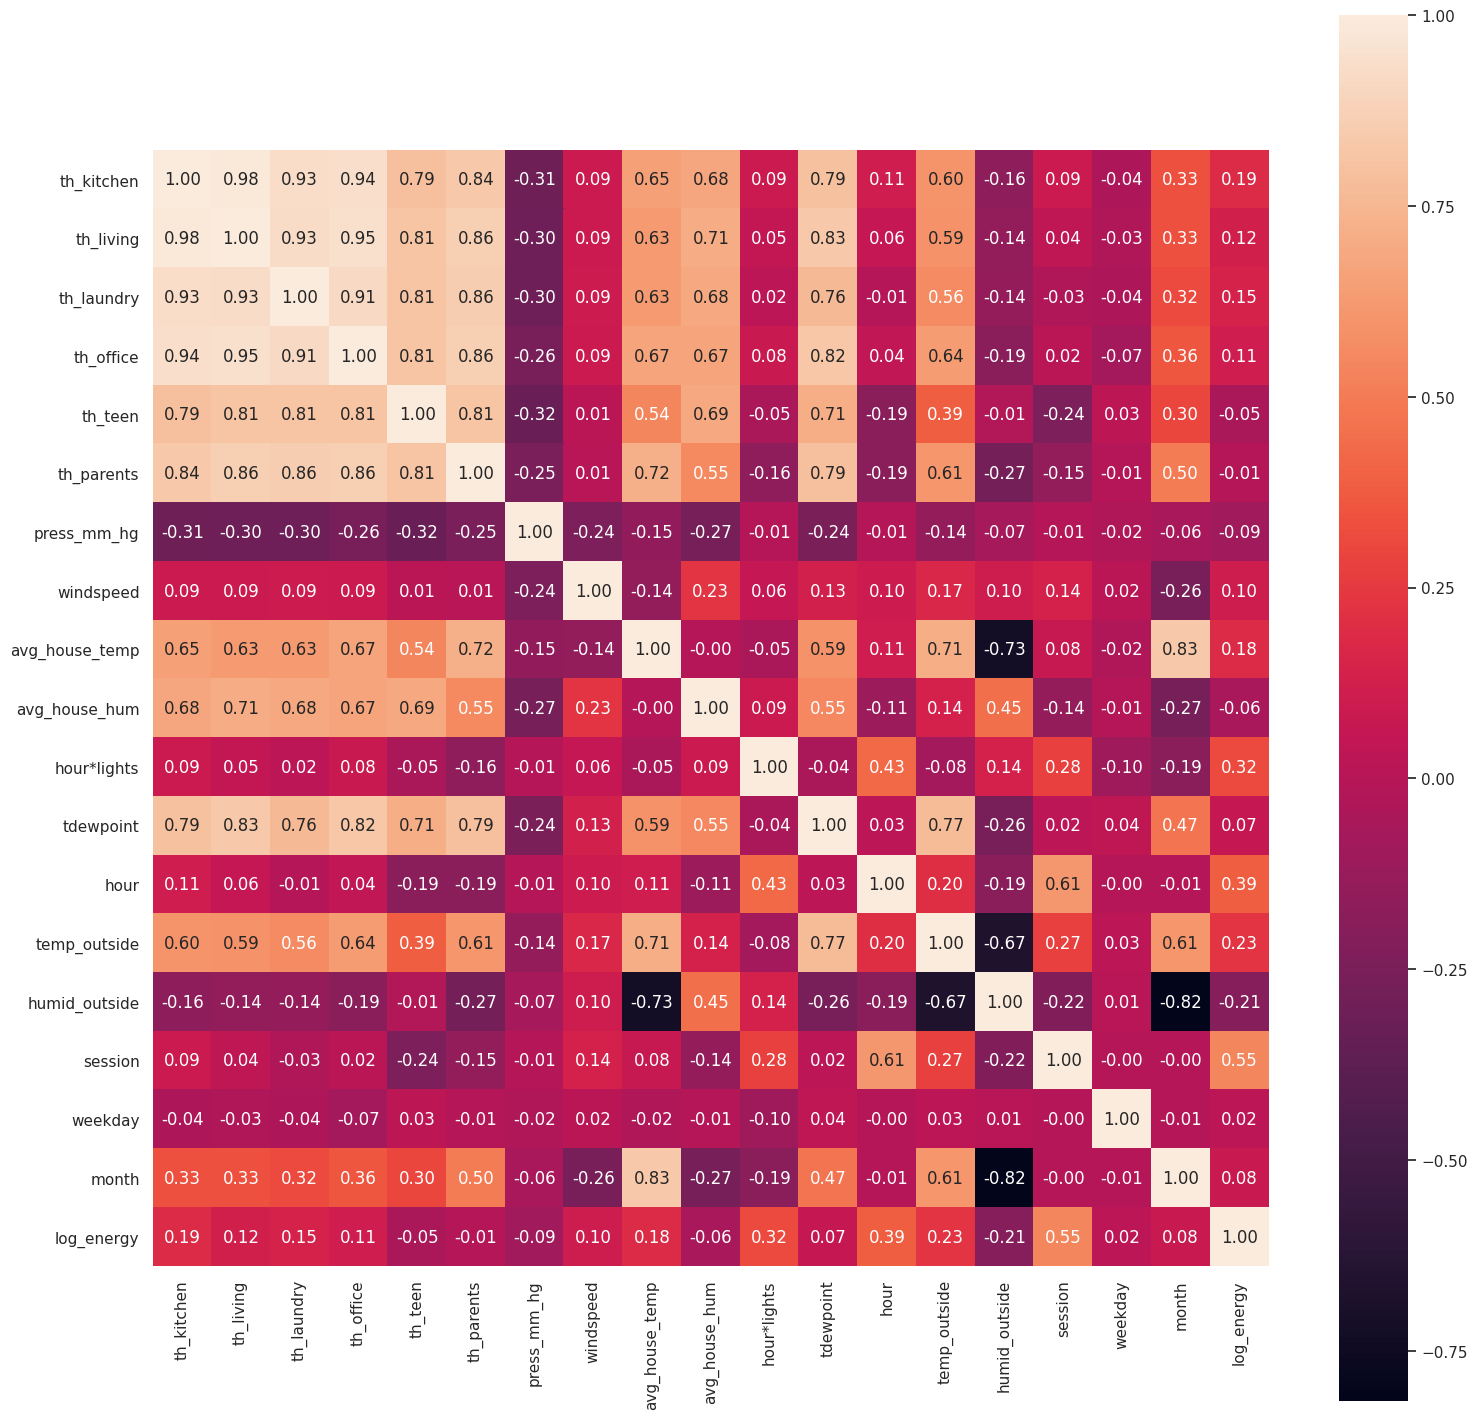

In [ ]:
# Pearson Correlation among the variables

col = ['th_kitchen', 'th_living', 'th_laundry', 
     'th_office',   'th_teen', 'th_parents', 
    'press_mm_hg',  'windspeed','avg_house_temp','avg_house_hum','hour*lights',
       'tdewpoint','hour','temp_outside','humid_outside','session','weekday','month','log_energy']

corr = energy_df_hour[col].corr()
plt.figure(figsize = (18,18))
sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.2f', xticklabels=col, yticklabels=col)
plt.show();

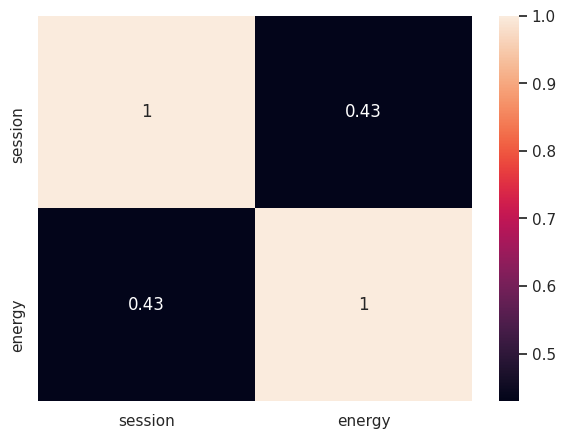

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
sns.heatmap(energy_df_hour[['session', 'energy']].corr(), ax = ax, annot=True)

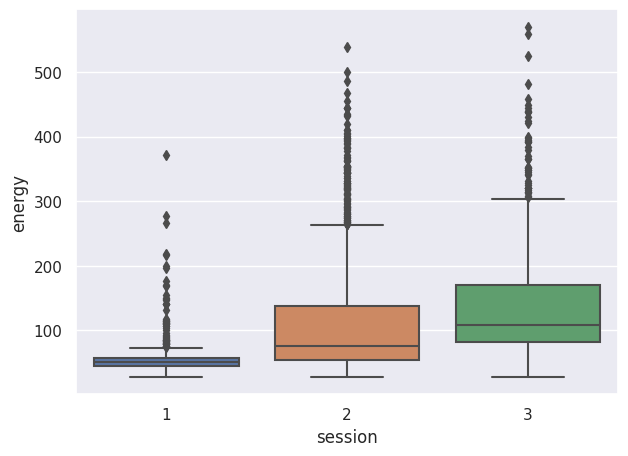

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
sns.boxplot(x='session',y='energy',data=energy_df_hour, ax = ax)

**We were now able to increase the correlation to 0.43 by making creating this new row. We see a clear distinction of power consumtion in different sessions.**

**Lets look at features related to weather as well.**

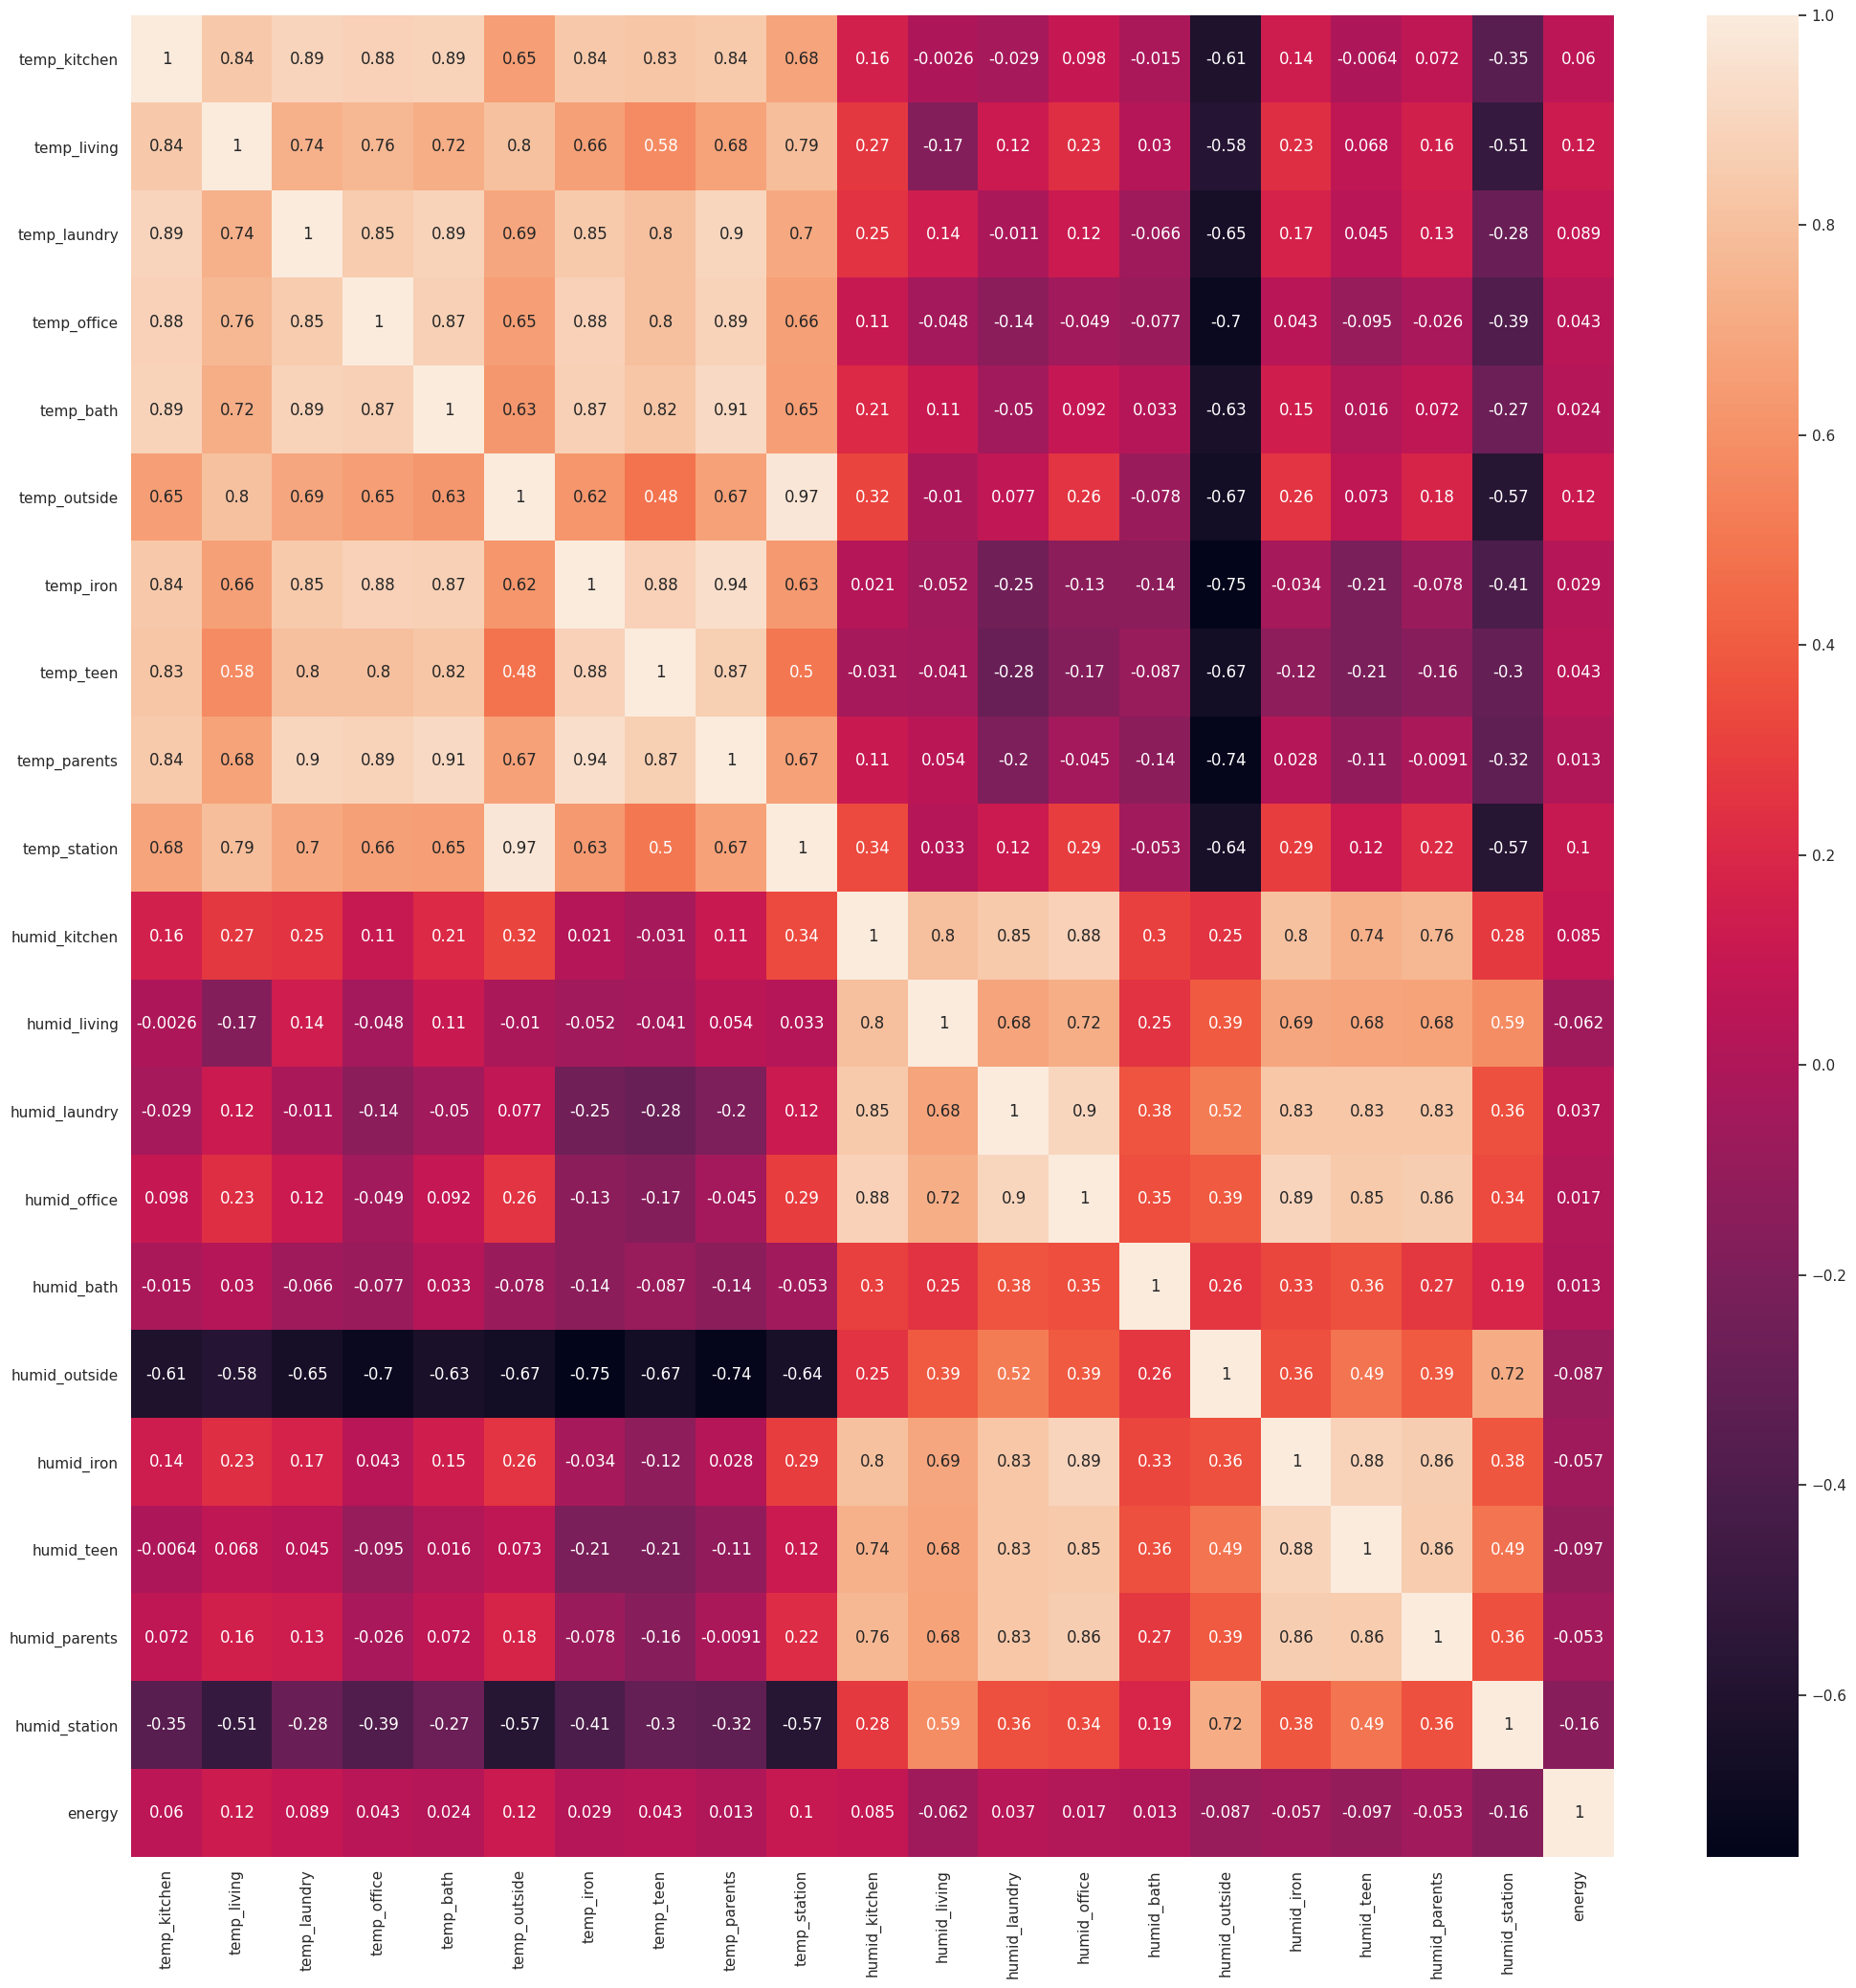

In [ ]:


cols = list(temp_dict.values())
cols.extend(list(humid_dict.values()))
cols.extend(['energy'])
fig, ax = plt.subplots(1,1,figsize=(25,25))
sns.heatmap(energy_df[cols].corr(), ax=ax, annot=True)

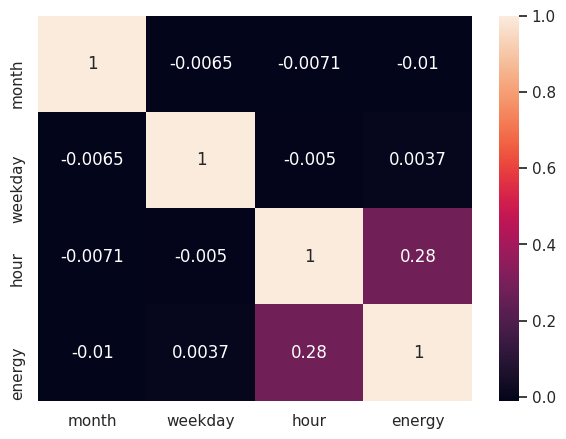

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
sns.heatmap(energy_df_hour[['month', 'weekday', 'hour', 'energy']].corr(), annot=True, ax=ax)

**Tdewpoint shows a high correlation with most of the tempearture and humidity level features than any other weather parameters. Pressure, windspeed and visibiltiy show little to know correlation. We might need to include these only these feaatures in our final model**

In [ ]:
temp_cols = list(set(list(temp_dict.values())) - {'temp_outside', 'temp_station'})
energy_df['mean_temp'] = energy_df[temp_cols].mean(axis=1)
energy_df[['mean_temp', 'energy']].corr()

mean_temp    energy
mean_temp   1.000000  0.058722
energy      0.058722  1.000000





##Modelling

In [ ]:
 final_features = ['th_kitchen', 'th_living', 'th_laundry', 
     'th_office',   'th_teen', 'th_parents', 
    'press_mm_hg',  'windspeed','avg_house_temp','avg_house_hum','hour*lights',
       'tdewpoint','hour','temp_outside','humid_outside','session','weekday','month','log_energy']


In [ ]:
final_train_df, final_test_df = train_test_split(energy_df[final_features], test_size = 0.2, random_state = 1)

In [ ]:
final_test_df.head()

th_kitchen  th_living  ...  month  log_energy
date                                         ...                   
2016-03-01 15:10:00   762.125000   715.4860  ...      3    3.688879
2016-01-13 02:30:00   840.768000   811.1325  ...      1    3.912023
2016-05-21 05:30:00  1052.177000  1008.0000  ...      5    3.912023
2016-02-21 00:20:00   945.686000   891.3828  ...      2    3.912023
2016-03-12 12:50:00   836.725556   683.6960  ...      3    4.941642

[5 rows x 19 columns]

In [ ]:
X_train, y_train = final_train_df.drop('log_energy', axis=1), final_train_df['log_energy']
X_test, y_test = final_test_df.drop('log_energy', axis=1), final_test_df['log_energy']

In [ ]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [ ]:
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train.values.reshape([-1,1])).flatten()
y_test = sc_y.transform(y_test.values.reshape([-1,1])).flatten()

**The ML regressor models that we use are :**
* **Lasso Regressor**
* **Ridge Regressor**
* **KNeighbors Regressor**
* **Support Vector Regressor**
* **Random Forest Regressor**
* **Extra Tree Regressor**
* **Gradient Boosting Regressor**
* **XGB Regressor**
* **MLP Regressor**

In [ ]:

from sklearn import linear_model

In [ ]:
models = [
           ['Lasso: ', Lasso()],
           ['Linear:',linear_model.LinearRegression()],
           ['Ridge: ', Ridge()],
           ['KNeighbors: ',  neighbors.KNeighborsRegressor()],
           #['SVR:' , SVR(kernel='rbf')],
           ['RandomForest ',RandomForestRegressor()],
           ['ExtraTrees :',ExtraTreesRegressor()],
           ['GradientBoost: ', GradientBoostingRegressor()],
           ['XGBoost: ', xgb.XGBRegressor()],
           #['MLPRegressor: ', MLPRegressor(  activation='relu', solver='adam',learning_rate='adaptive',max_iter=1000,learning_rate_init=0.01,alpha=0.01)]
         ]

In [ ]:
#Predicting and evaluating models
model_data = []
for name,curr_model in models :
    curr_model_data = {}
    curr_model.random_state = 78
    curr_model_data["Name"] = name
    start = time.time()
    curr_model.fit(X_train,y_train)
    end = time.time()
   
    curr_model_data["Train_Time"] = end - start
    curr_model_data["Train_R2_Score"] = 100*r2_score(y_train,curr_model.predict(X_train))
    curr_model_data["Test_R2_Score"] = 100*r2_score(y_test,curr_model.predict(X_test))
    
    model_data.append(curr_model_data)

[09:56:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
results_df = pd.DataFrame(model_data)

In [ ]:
results_df

Name  Train_Time  Train_R2_Score  Test_R2_Score
0          Lasso:     0.013341        0.000000      -0.011097
1          Linear:    0.020216       30.056194      28.740263
2          Ridge:     0.008848       30.056186      28.740768
3      KNeighbor:     0.277368       75.732004      61.003093
4    RandomForest    23.045660       95.659244      67.462495
5      ExtraTree :    6.263571      100.000000      73.276457
6  GradientBoost:     7.554908       47.107154      42.282183
7        XGBoost:     1.668026       46.936698      42.162686

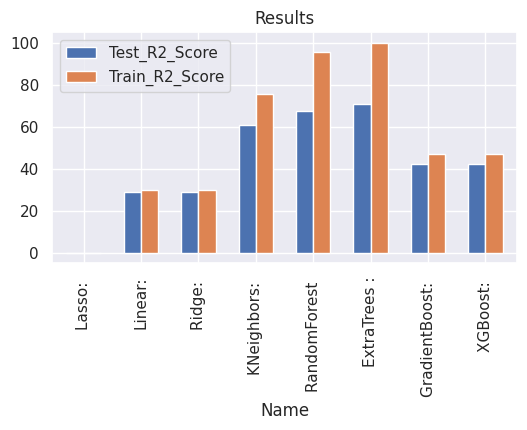

In [ ]:

results_df.plot.bar(x="Name", y=['Test_R2_Score' , 'Train_R2_Score' ], title = 'Results' , width = .6, figsize= (6,3))


##PCA


###PCA on temperatures

In [ ]:
train_energy_df, test_energy_df = train_test_split(energy_df, test_size=0.2, random_state=1)

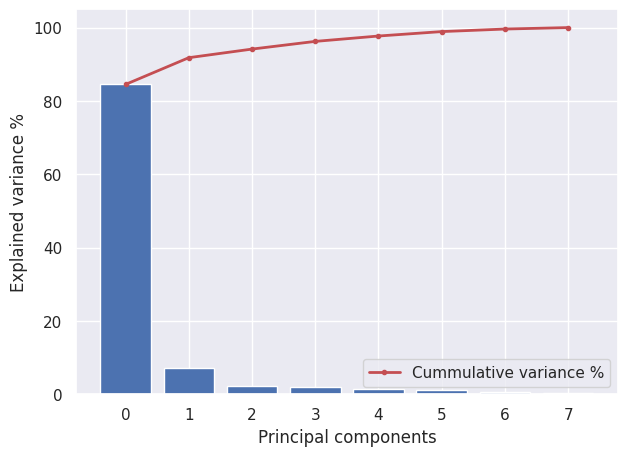

In [ ]:
pca = PCA()
pca.fit(train_energy_df[temp_cols])
temp_pca = pca.transform(energy_df[temp_cols])
variance = pca.explained_variance_ratio_*100
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.bar(range(len(variance)), variance)
ax.plot(range(len(variance)), np.cumsum(variance),'r.-',linewidth=2, label='Cummulative variance %')
ax.set_xlabel('Principal components')
ax.set_ylabel('Explained variance %')
plt.legend(loc='best')

In [ ]:
variance

array([84.49884428,  7.29011762,  2.348214  ,  2.09676706,  1.46620718,
        1.20764113,  0.69432349,  0.39788525])

First two components seem to explain more than 91 % of variance in data.

In [ ]:
for i in range(temp_pca.shape[1]):
  energy_df[f'temp_pca{i+1}'] = temp_pca[:,i]

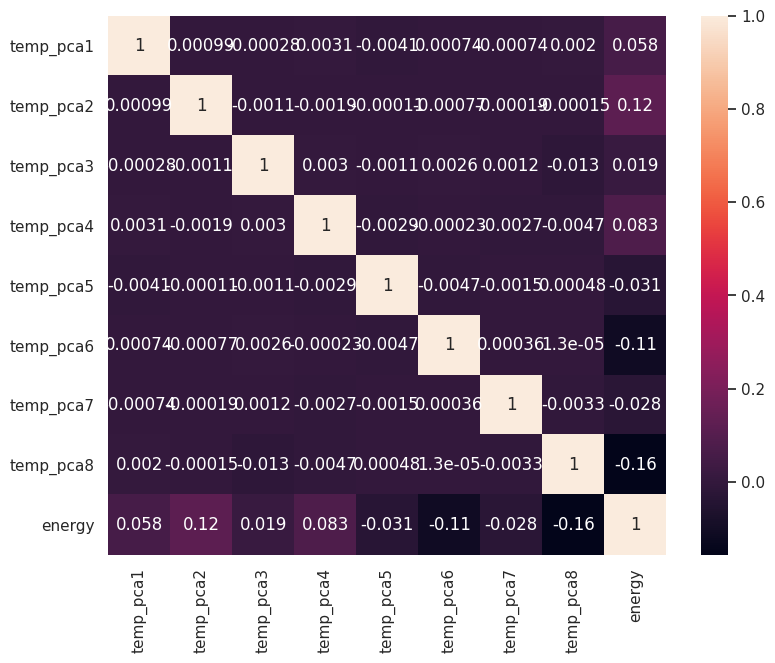

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(9,7))
sns.heatmap(energy_df[['temp_pca1', 'temp_pca2', 'temp_pca3', 'temp_pca4','temp_pca5', 'temp_pca6', 'temp_pca7', 'temp_pca8', 'energy']].corr(), ax = ax, annot=True)

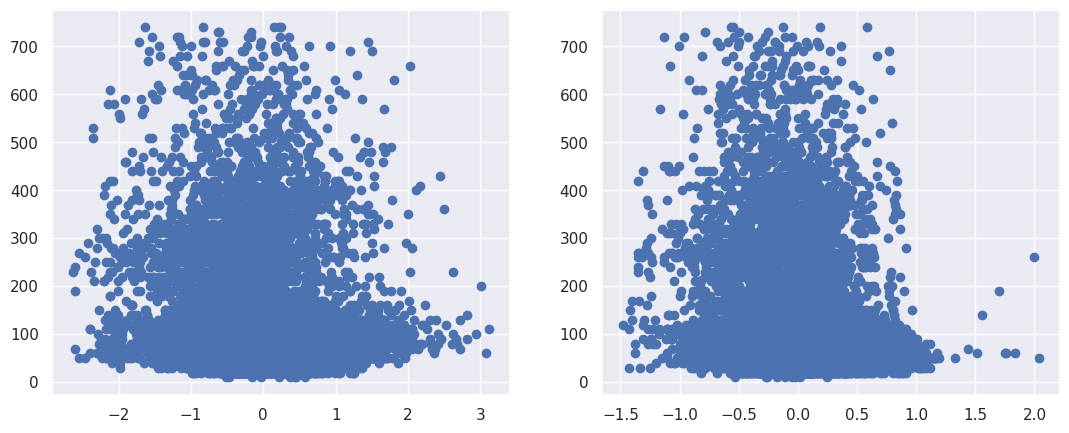

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(13,5))
for i, j in enumerate((6,8)):
  axes[i].scatter(energy_df[f'temp_pca{j}'], energy_df['energy'])

In [ ]:
#Lets look at components of humid_pca4
dict(zip(temp_cols, pca.components_[7,:]))

{'temp_bath': -0.22131363998805628,
 'temp_iron': -0.24884346702916316,
 'temp_kitchen': 0.6106164199967877,
 'temp_laundry': -0.29474796344714566,
 'temp_living': -0.1134009272189793,
 'temp_office': -0.09458694968857963,
 'temp_parents': 0.6154922966973716,
 'temp_teen': -0.1695027985222956}

###PCA on humidity

In [ ]:
humid_cols = list(set(list(humid_dict.values())) - {'humid_outside', 'humid_station'})
energy_df['mean_humid'] = energy_df[temp_cols].mean(axis=1)
energy_df[['mean_humid', 'energy']].corr()

mean_humid    energy
mean_humid    1.000000  0.058722
energy        0.058722  1.000000

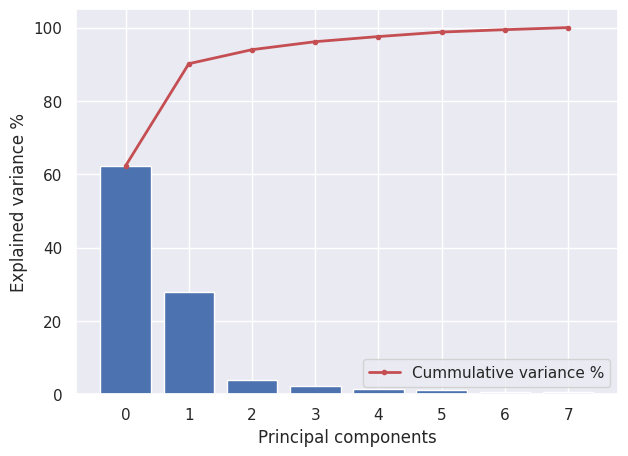

In [ ]:
pca = PCA()
pca.fit(train_energy_df[humid_cols])
humid_pca = pca.transform(energy_df[humid_cols])
variance = pca.explained_variance_ratio_*100
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.bar(range(len(variance)), variance)
ax.plot(range(len(variance)), np.cumsum(variance),'r.-',linewidth=2, label='Cummulative variance %')
ax.set_xlabel('Principal components')
ax.set_ylabel('Explained variance %')
plt.legend(loc='best')

In [ ]:
variance

array([62.28448746, 27.86413499,  3.82908792,  2.17757202,  1.39919079,
        1.23017808,  0.64288879,  0.57245995])

In [ ]:
for i in range(humid_pca.shape[1]):
  energy_df[f'humid_pca{i+1}'] = humid_pca[:,i]

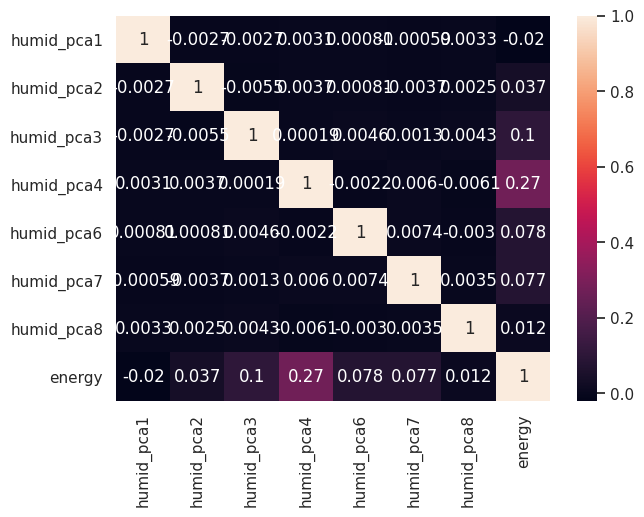

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
sns.heatmap(energy_df[['humid_pca1', 'humid_pca2', 'humid_pca3', 'humid_pca4', 'humid_pca6', 'humid_pca7', 'humid_pca8', 'energy']].corr(), ax = ax, annot=True)

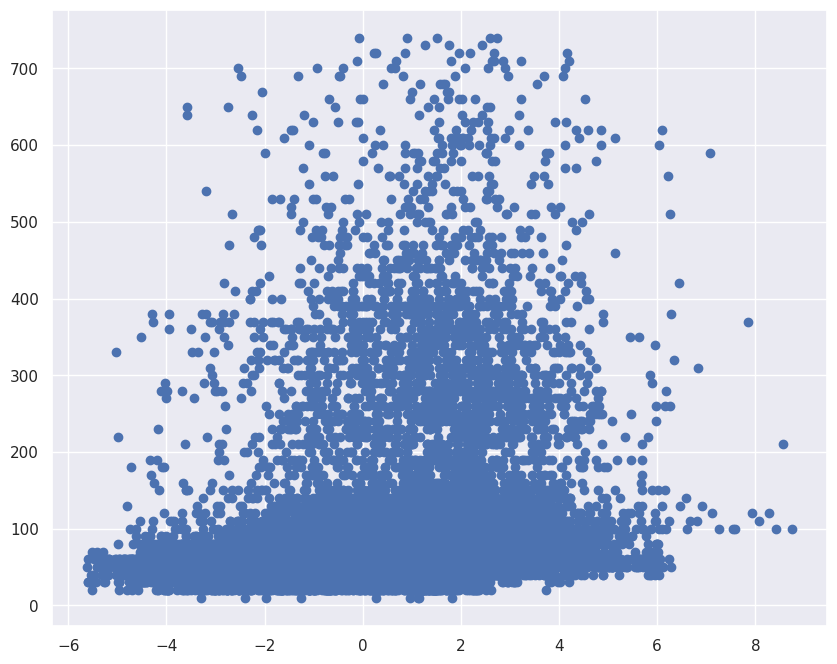

In [ ]:
plt.scatter(energy_df['humid_pca4'], energy_df['energy'])

In [ ]:
#Lets look at components of humid_pca4
dict(zip(humid_cols, pca.components_[3,:]))

{'humid_bath': -0.005023746850103095,
 'humid_iron': 0.07018355066528524,
 'humid_kitchen': 0.4076660494504183,
 'humid_laundry': 0.2997732719384193,
 'humid_living': -0.538540736885233,
 'humid_office': 0.4111860259261362,
 'humid_parents': -0.0083761956158903,
 'humid_teen': -0.528983151797491}

In [ ]:
energy_df['diff_temp'] = energy_df['temp_outside'] - energy_df['mean_temp']
energy_df[['diff_temp', 'energy']].corr()

diff_temp    energy
diff_temp   1.000000  0.128567
energy      0.128567  1.000000

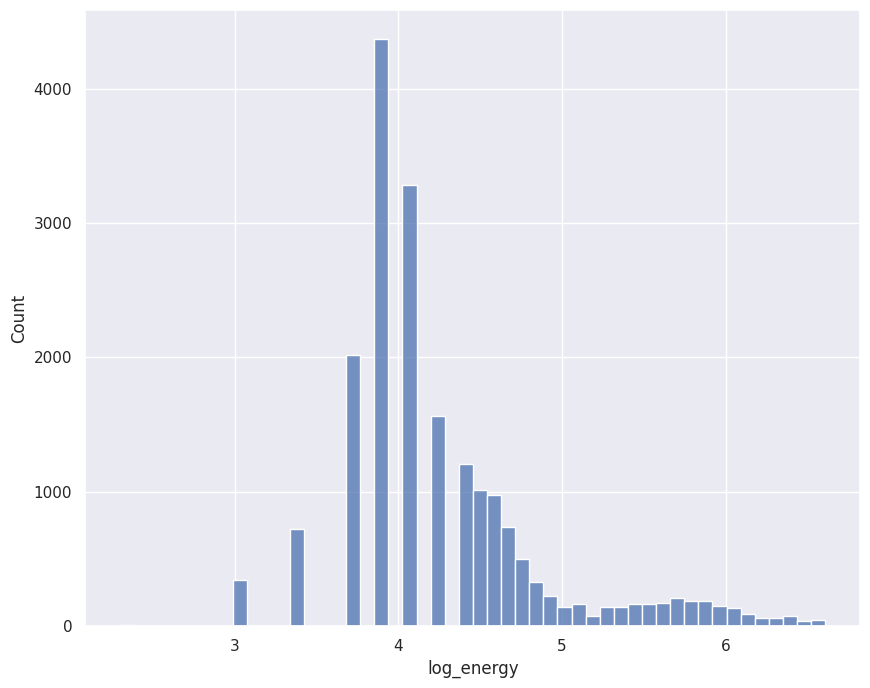

In [ ]:

sns.histplot(energy_df.log_energy,bins=50)

In [ ]:
energy_df.head()

energy  lights  ...  humid_pca8  diff_temp
date                                 ...                       
2016-01-11 17:00:00      60      30  ...    0.427836 -11.408333
2016-01-11 17:10:00      60      30  ...    0.299026 -11.605833
2016-01-11 17:20:00      50      30  ...    0.491276 -11.861667
2016-01-11 17:30:00      50      40  ...    0.649424 -11.962917
2016-01-11 17:40:00      60      40  ...    0.716628 -12.042083

[5 rows x 65 columns]

###Modeling with PCA features

In [ ]:
final_features = ['temp_pca1', 'temp_pca2','temp_pca6','humid_pca1', 'humid_pca2', 'humid_pca4', 'temp_outside', 'humid_outside', 'weekday', 'session', 'windspeed', 'press_mm_hg', 'log_energy']

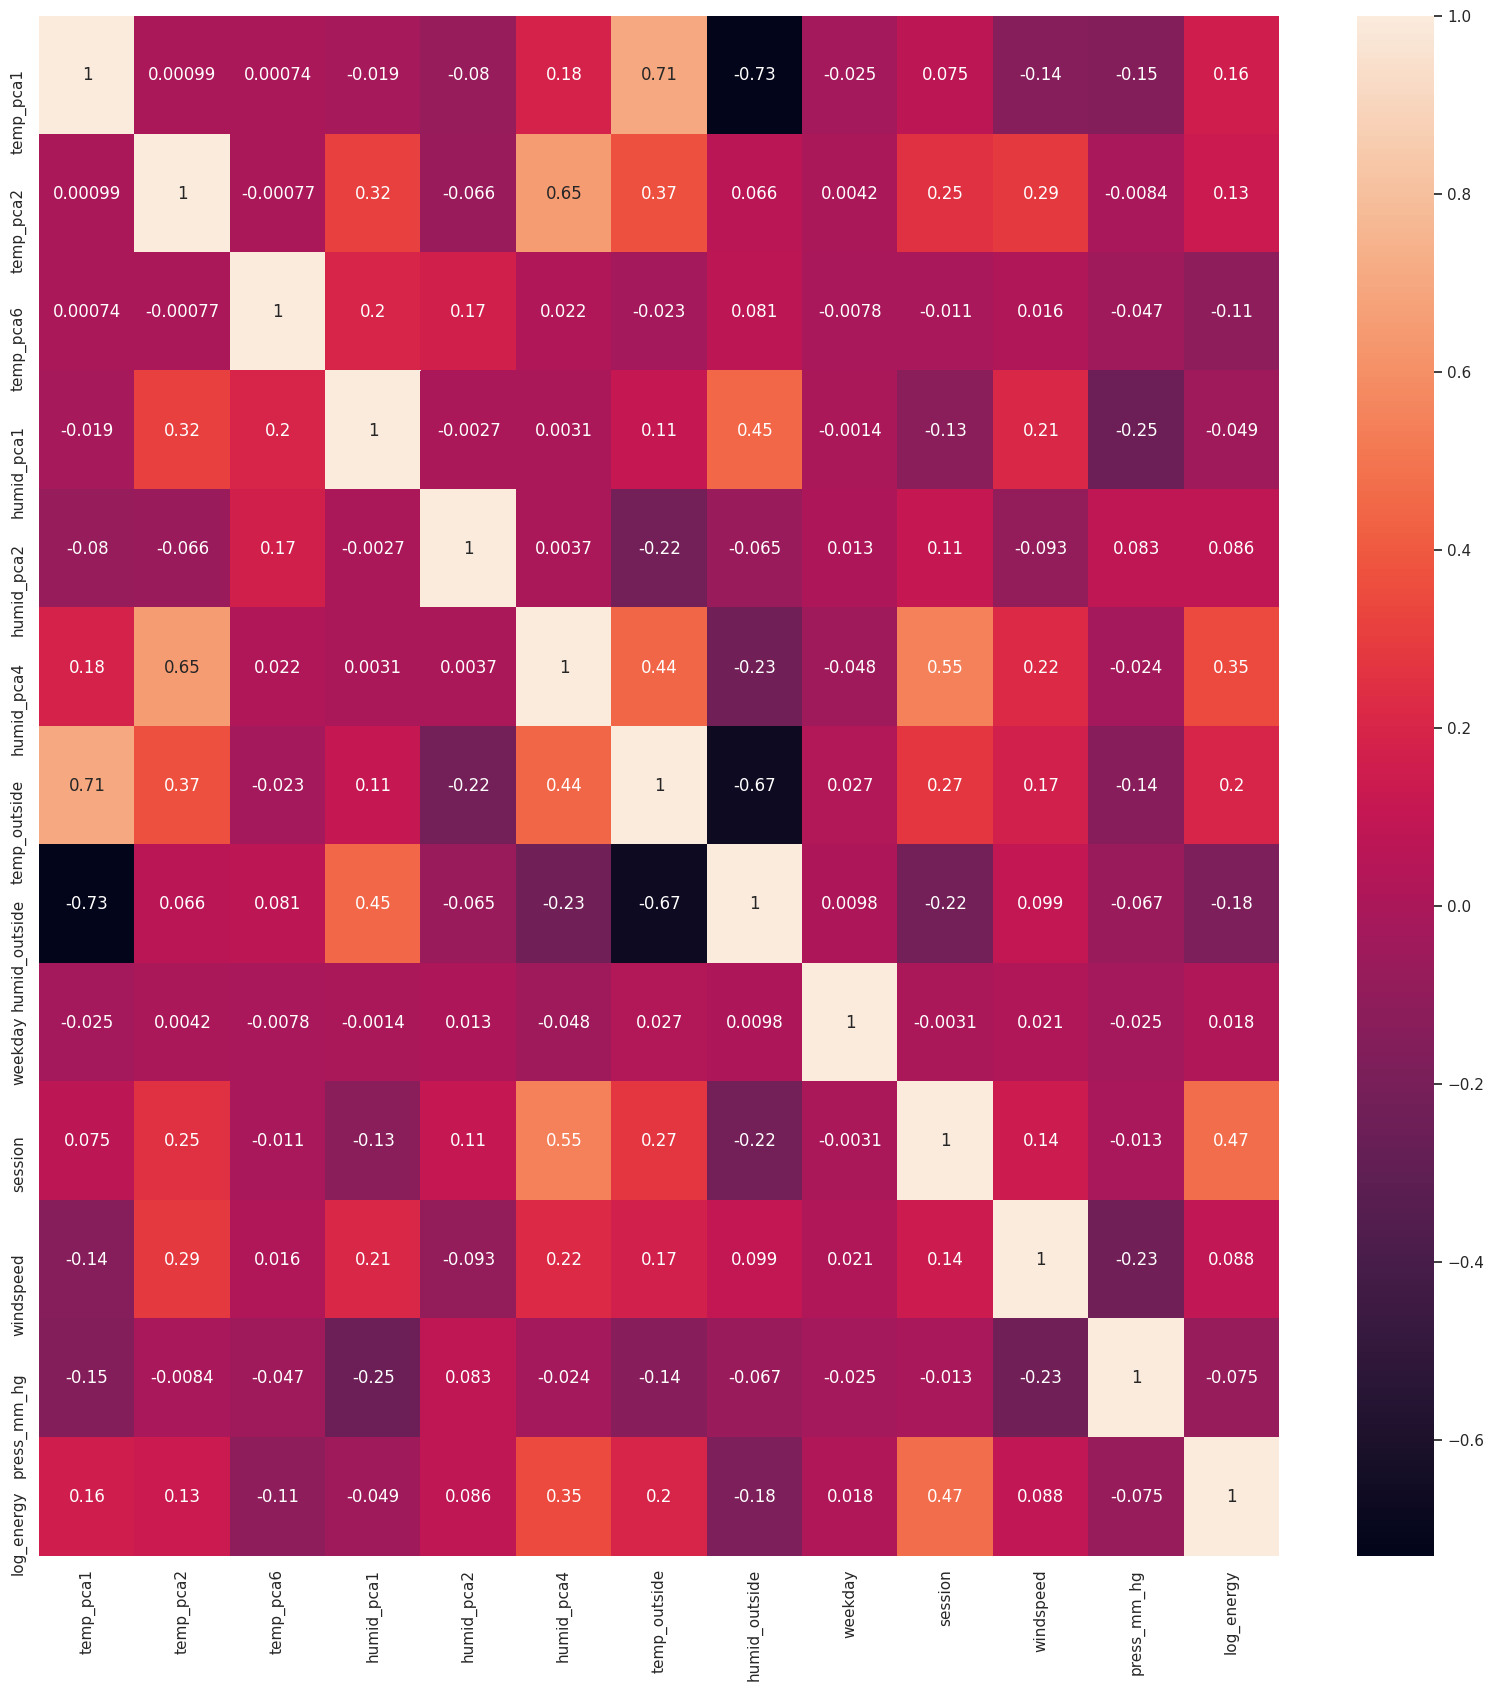

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,20))
sns.heatmap(energy_df[final_features].corr(), ax = ax, annot=True)


In [ ]:
pca_train_df, pca_test_df = train_test_split(energy_df[final_features], test_size = 0.2, random_state = 1)

In [ ]:
pca_X_train, pca_y_train = pca_train_df.drop('log_energy', axis=1), pca_train_df['log_energy']
pca_X_test, pca_y_test = pca_test_df.drop('log_energy', axis=1), pca_test_df['log_energy']

In [ ]:
sc_X = StandardScaler()
pca_X_train = sc_X.fit_transform(pca_X_train)
pca_X_test = sc_X.transform(pca_X_test)

In [ ]:
sc_y = StandardScaler()
pca_y_train = sc_y.fit_transform(pca_y_train.values.reshape([-1,1])).flatten()
pca_y_test = sc_y.transform(pca_y_test.values.reshape([-1,1])).flatten()

**The ML regressor models that we use are :**
* **Lasso Regressor**
* **Ridge Regressor**
* **KNeighbors Regressor**
* **Support Vector Regressor**
* **Random Forest Regressor**
* **Extra Tree Regressor**
* **Gradient Boosting Regressor**
* **XGB Regressor**
* **MLP Regressor**

In [ ]:
models = [
           ['Lasso: ', Lasso()],
           ['Linear:', linear_model.LinearRegression()],
           ['Ridge: ', Ridge()],
           ['KNeighborsRegressor: ',  neighbors.KNeighborsRegressor()],
           ['SVR:' , SVR(kernel='rbf')],
           ['RandomForest ',RandomForestRegressor()],
           ['ExtraTreeRegressor :',ExtraTreesRegressor()],
           ['GradientBoostingRegressor: ', GradientBoostingRegressor()] ,
           ['XGBRegressor: ', xgb.XGBRegressor()] ,
           ['MLPRegressor: ', MLPRegressor(  activation='relu', solver='adam',learning_rate='adaptive',max_iter=1000,learning_rate_init=0.01,alpha=0.01)]
         ]

In [ ]:
pca_model_data = []
for name,curr_model in models :
    curr_model_data = {}
    curr_model.random_state = 78
    curr_model_data["Name"] = name

    start = time.time()
    curr_model.fit(pca_X_train,pca_y_train)
    end = time.time()
    curr_model_data["Train_Time"] = end - start
    curr_model_data["Train_R2_Score"] = 100*r2_score(pca_y_train,curr_model.predict(pca_X_train))
    curr_model_data["Test_R2_Score"] = 100*r2_score(pca_y_test,curr_model.predict(pca_X_test))
    #curr_model_data["Test_RMSE_Score"] = np.sqrt(mean_squared_error(y_test,curr_model.predict(X_test)))
    pca_model_data.append(curr_model_data)

[08:56:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
results_df_pca =  pd.DataFrame(pca_model_data)

In [ ]:
results_df_pca

Name  Train_Time  Train_R2_Score  Test_R2_Score
0                      Lasso:     0.009820        0.000000      -0.011097
1                      Linear:    0.019517       26.978211      27.151996
2                      Ridge:     0.002796       26.978210      27.152002
3        KNeighborsRegressor:     0.043553       77.373950      64.016633
4                         SVR:   18.657409       48.072361      45.500650
5                RandomForest    18.128670       95.788291      70.153800
6         ExtraTreeRegressor :    4.870711      100.000000      74.510295
7  GradientBoostingRegressor:     5.725876       43.061448      40.222988
8               XGBRegressor:     1.323904       43.131974      39.934806
9               MLPRegressor:     6.066092       55.278368      50.600284

**OBSERVATIONS :**

* **Extra Tree Regressor performs the best so far with a R2 score of 0.744**
* **Lasso regression is the worst performing model so far.**

## Plotting prediction

In [ ]:

lin_model = linear_model.LinearRegression()
etr_model = ExtraTreesRegressor()
rf_model = RandomForestRegressor()

In [ ]:
lin_model.fit(X_train,y_train)

rf_model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
etr_model.fit(X_train,y_train)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [ ]:
y1_pred = lin_model.predict(X_test)
y2_pred = etr_model.predict(X_test)
y3_pred = rf_model.predict(X_test)

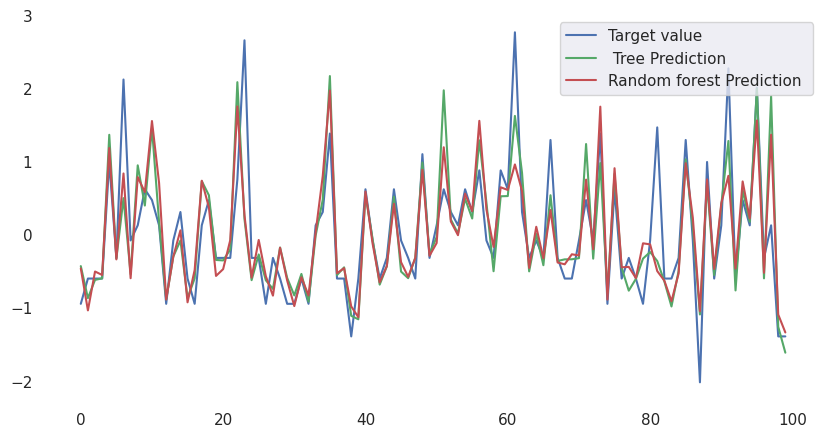

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes(facecolor ='white')
plt.plot(y_test[:100],label='Target value',color='b')
plt.plot(y2_pred[:100],label=' Tree Prediction ', linestyle='-', color='g')
plt.plot(y3_pred[:100],label='Random forest Prediction ', linestyle='-', color='r')
plt.legend(loc=1)

## Baseline model

In [ ]:
df.head()

date  appliances  lights  ...  tdewpoint        rv1        rv2
0 2016-01-11 17:00:00          60      30  ...        5.3  13.275433  13.275433
1 2016-01-11 17:10:00          60      30  ...        5.2  18.606195  18.606195
2 2016-01-11 17:20:00          50      30  ...        5.1  28.642668  28.642668
3 2016-01-11 17:30:00          50      40  ...        5.0  45.410389  45.410389
4 2016-01-11 17:40:00          60      40  ...        4.9  10.084097  10.084097

[5 rows x 29 columns]

In [ ]:
# Append more columns to the DataFrame based on datetime
df = df.set_index('date')
df['month'] = df.index.month
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour
df['week'] = df.index.week

In [ ]:
df.columns

Index(['appliances', 'lights', 't1', 'rh_1', 't2', 'rh_2', 't3', 'rh_3', 't4',
       'rh_4', 't5', 'rh_5', 't6', 'rh_6', 't7', 'rh_7', 't8', 'rh_8', 't9',
       'rh_9', 't_out', 'press_mm_hg', 'rh_out', 'windspeed', 'visibility',
       'tdewpoint', 'rv1', 'rv2', 'month', 'weekday', 'hour', 'week'],
      dtype='object')

In [ ]:
features =[ 'appliances', 'lights', 't1', 'rh_1', 't2', 'rh_2', 't3', 'rh_3', 't4',
       'rh_4', 't5', 'rh_5', 't6', 'rh_6', 't7', 'rh_7', 't8', 'rh_8', 't9',
       'rh_9', 't_out', 'press_mm_hg', 'rh_out', 'windspeed', 'visibility',
       'tdewpoint', 'rv1', 'rv2', 'month', 'weekday', 'hour', 'week']

In [ ]:
df_train_df, df_test_df = train_test_split(df[features], test_size = 0.2, random_state = 1)

In [ ]:
df_X_train, df_y_train = df_train_df.drop('appliances', axis=1), df_train_df['appliances']
df_X_test, df_y_test = df_test_df.drop('appliances', axis=1), df_test_df['appliances']

In [ ]:
sc_X = StandardScaler()
df_X_train = sc_X.fit_transform(df_X_train)
df_X_test = sc_X.transform(df_X_test)

In [ ]:
sc_y = StandardScaler()
df_y_train = sc_y.fit_transform(df_y_train.values.reshape([-1,1])).flatten()
df_y_test = sc_y.transform(df_y_test.values.reshape([-1,1])).flatten()

**The ML regressor models that we use are :**
* **Lasso Regressor**
* **Ridge Regressor**
* **KNeighbors Regressor**
* **Support Vector Regressor**
* **Random Forest Regressor**
* **Extra Tree Regressor**
* **Gradient Boosting Regressor**
* **XGB Regressor**
* **MLP Regressor**

In [ ]:
models = [
           ['Lasso: ', Lasso()],
           ['Linear:', linear_model.LinearRegression()],
           ['Ridge: ', Ridge()],
           ['KNeighborsRegressor: ',  neighbors.KNeighborsRegressor()],
           ['SVR:' , SVR(kernel='rbf')],
           ['RandomForest ',RandomForestRegressor()],
           ['ExtraTreeRegressor :',ExtraTreesRegressor()],
           ['GradientBoostingRegressor: ', GradientBoostingRegressor()] ,
           ['XGBRegressor: ', xgb.XGBRegressor()] ,
           ['MLPRegressor: ', MLPRegressor(  activation='relu', solver='adam',learning_rate='adaptive',max_iter=1000,learning_rate_init=0.01,alpha=0.01)]
         ]

In [ ]:
baseline_model_data = []
for name,curr_model in models :
    curr_model_data = {}
    curr_model.random_state = 78
    curr_model_data["Name"] = name

    start = time.time()
    curr_model.fit(df_X_train,df_y_train)
    end = time.time()
    curr_model_data["Train_Time"] = end - start
    curr_model_data["Train_R2_Score"] = 100*r2_score(df_y_train,curr_model.predict(df_X_train))
    curr_model_data["Test_R2_Score"] = 100*r2_score(df_y_test,curr_model.predict(df_X_test))
    #curr_model_data["Test_RMSE_Score"] = np.sqrt(mean_squared_error(y_test,curr_model.predict(X_test)))
    baseline_model_data.append(curr_model_data)

[08:59:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
results_df_baseline =  pd.DataFrame(baseline_model_data)

In [ ]:
results_df_baseline

Name  Train_Time  Train_R2_Score  Test_R2_Score
0                      Lasso:     0.009571        0.000000      -0.077728
1                      Linear:    0.044318       16.916934      16.965530
2                      Ridge:     0.015135       16.916887      16.965907
3        KNeighborsRegressor:     0.184476       58.843018      34.417502
4                         SVR:   20.565121       27.863664      24.122758
5                RandomForest    42.285551       93.439715      52.899138
6         ExtraTreeRegressor :   11.371802      100.000000      59.396194
7  GradientBoostingRegressor:    10.788517       36.836442      29.285561
8               XGBRegressor:     2.173567       36.810097      29.581404
9               MLPRegressor:    15.077727       51.975938      37.087464

### Plotting prediction

In [ ]:

lin_model = linear_model.LinearRegression()
#etr_model = ExtraTreesRegressor(max_depth=80, max_features= 'sqrt', n_estimators=250)
#rf_model = RandomForestRegressor()

In [ ]:
lin_model.fit(df_X_train,df_y_train)

#rf_model.fit(pca_X_train,pca_y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#etr_model.fit(pca_X_train,pca_y_train)

In [ ]:
y1_pred = lin_model.predict(df_X_test)
#y2_pred = etr_model.predict(pca_X_test)
#y3_pred = rf_model.predict(pca_X_test)

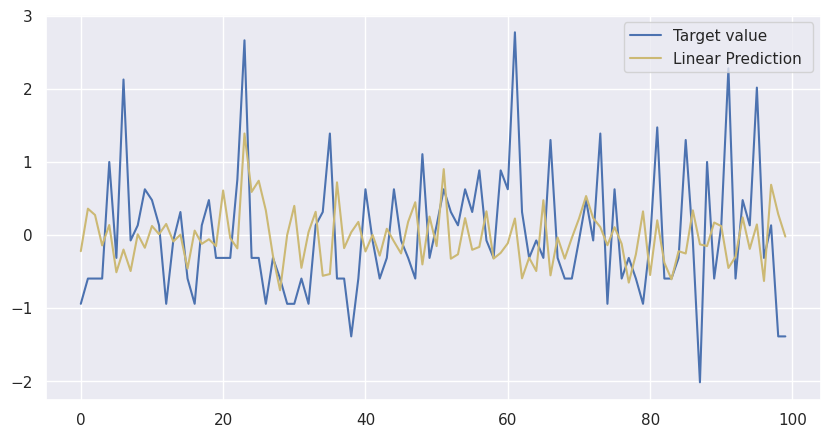

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot(y_test[:100],label='Target value',color='b')
plt.plot(y1_pred[:100],label='Linear Prediction ', linestyle='-', color='y')
#plt.plot(y2_pred[:100],label=' Tree Prediction ', linestyle='-', color='g')

#plt.plot(y3_pred[:100],label='Random forest Prediction ', linestyle='-', color='r')


plt.legend(loc=1)

##Hyper parameter tuning

In [ ]:
param_grid = [{
              'max_depth': [80, 150, 200,250],
              'n_estimators' : [100,150,200,250],
              'max_features': ["auto", "sqrt", "log2"]
            }]
reg = ExtraTreesRegressor(random_state=40)
grid_search = GridSearchCV(estimator = reg, param_grid = param_grid, cv = 5, n_jobs = -1 , scoring='r2' , verbose=2)
grid_search.fit(pca_X_train, pca_y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 13.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=None,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=None,
                                           oob_score=False, random_state=40,
                                           verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_g

In [ ]:
grid_search.best_params_

{'max_depth': 80, 'max_features': 'sqrt', 'n_estimators': 250}

In [ ]:
grid_search.best_estimator_

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=80, max_features='sqrt', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=250, n_jobs=None, oob_score=False,
                    random_state=40, verbose=0, warm_start=False)

In [ ]:
grid_search.best_estimator_.score(pca_X_train,pca_y_train)

1.0

In [ ]:
grid_search.best_estimator_.score(pca_X_test,pca_y_test)

0.7422541761724135

In [ ]:
models = [
           ['Lasso: ', Lasso()],
           ['Linear:', linear_model.LinearRegression()],
           ['Ridge: ', Ridge()],
           ['KNeighbor: ',  neighbors.KNeighborsRegressor()],
           #['SVR:' , SVR(kernel='rbf')],
           ['RandomForest ',RandomForestRegressor()],
           ['ExtraTree :',ExtraTreesRegressor(max_depth=80, max_features= 'sqrt', n_estimators=250)],
           ['GradientBoost: ', GradientBoostingRegressor()] ,
           ['XGBoost: ', xgb.XGBRegressor()] ,
           #['MLPRegressor: ', MLPRegressor(  activation='relu', solver='adam',learning_rate='adaptive',max_iter=1000,learning_rate_init=0.01,alpha=0.01)]
         ]

In [ ]:
pca_model_data = []
for name,curr_model in models :
    curr_model_data = {}
    curr_model.random_state = 78
    curr_model_data["Name"] = name

    start = time.time()
    curr_model.fit(pca_X_train,pca_y_train)
    end = time.time()
    curr_model_data["Train_Time"] = end - start
    curr_model_data["Train_R2_Score"] = 100*r2_score(pca_y_train,curr_model.predict(pca_X_train))
    curr_model_data["Test_R2_Score"] = 100*r2_score(pca_y_test,curr_model.predict(pca_X_test))
    #curr_model_data["Test_RMSE_Score"] = np.sqrt(mean_squared_error(y_test,curr_model.predict(X_test)))
    pca_model_data.append(curr_model_data)

[09:13:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
results_df_pca_hy =  pd.DataFrame(pca_model_data)

In [ ]:
results_df_pca_hy

Name  Train_Time  Train_R2_Score  Test_R2_Score
0          Lasso:     0.012010        0.000000      -0.011097
1          Linear:    0.008584       26.978211      27.151996
2          Ridge:     0.005704       26.978210      27.152002
3      KNeighbor:     0.076728       77.373950      64.016633
4    RandomForest    17.854974       95.788291      70.153800
5      ExtraTree :    5.715688      100.000000      74.496249
6  GradientBoost:     5.726156       43.061448      40.222988
7        XGBoost:     1.290702       43.131974      39.934806

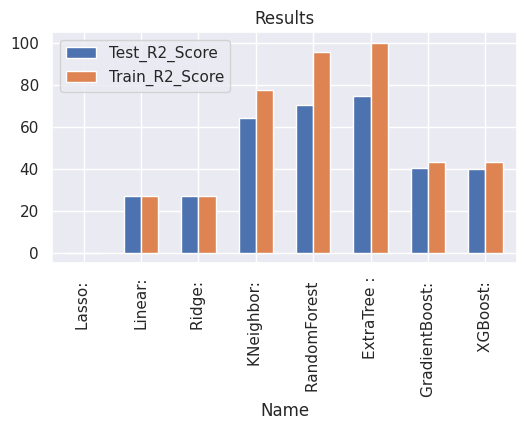

In [ ]:
#plot.xticks(rotation = 45)
results_df_pca_hy.plot.bar(x="Name", y=['Test_R2_Score' , 'Train_R2_Score' ], title = 'Results' , width = .6 ,figsize= (6,3))

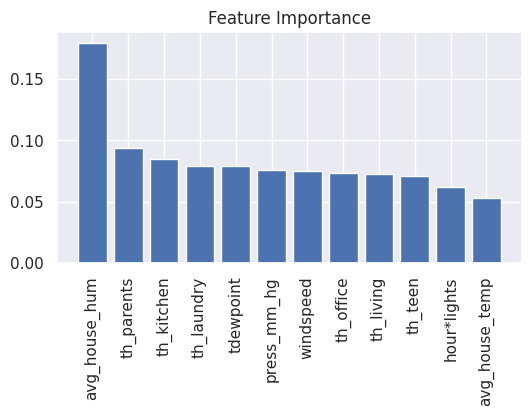

In [ ]:
feature_indices = np.argsort(grid_search.best_estimator_.feature_importances_)
importances = grid_search.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
names = [final_train_df.columns[i] for i in indices]

plt.figure(figsize=(6,3))
plt.title("Feature Importance")
plt.bar(range(pca_X_train.shape[1]), importances[indices])
plt.xticks(range(pca_X_train.shape[1]), names, rotation=90)
plt.show()

## Plotting prediction

In [ ]:

lin_model = linear_model.LinearRegression()
etr_model = ExtraTreesRegressor(max_depth=80, max_features= 'sqrt', n_estimators=250)
rf_model = RandomForestRegressor()

In [ ]:
lin_model.fit(pca_X_train,pca_y_train)

rf_model.fit(pca_X_train,pca_y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
etr_model.fit(pca_X_train,pca_y_train)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=80, max_features='sqrt', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=250, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [ ]:
y1_pred = lin_model.predict(pca_X_test)
y2_pred = etr_model.predict(pca_X_test)
y3_pred = rf_model.predict(pca_X_test)

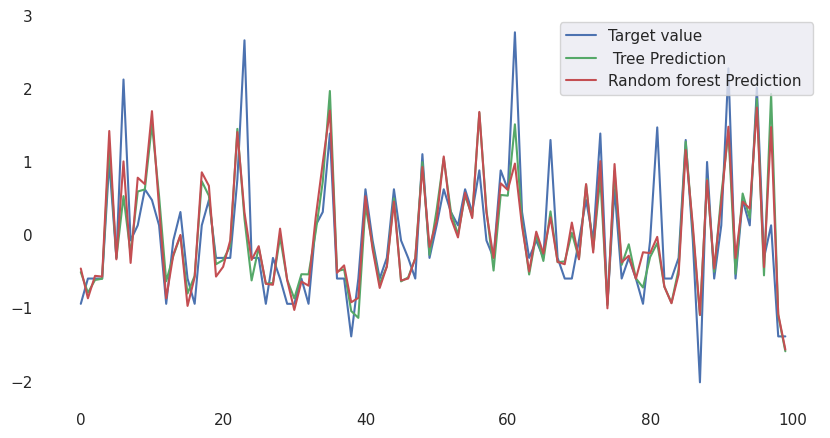

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes(facecolor ='white')
#plt.grid(color='black', linestyle='solid')

plt.plot(y_test[:100],label='Target value',color='b')
#plt.plot(y1_pred,label='Linear Prediction ', linestyle='--', color='y')
plt.plot(y2_pred[:100],label=' Tree Prediction ', linestyle='-', color='g')

plt.plot(y3_pred[:100],label='Random forest Prediction ', linestyle='-', color='r')


plt.legend(loc=1)